In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from sklearn import preprocessing

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## noncyclic Stocks

### Kweichow Moutai Co., Ltd.

In [5]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14        OBV_7  labels
0  2001-09-14     7.142585  7.257483 -41.873824  204624213.0     2.0
1  2001-09-17     7.224180  7.252359 -51.296847  208479649.0     2.0
2  2001-09-18     7.132634  7.233940 -72.964156  203965392.0     2.0
3  2001-09-19     7.214230  7.230908 -59.609037  209378730.0     2.0
4  2001-09-20     7.347568  7.248855 -37.785092  213725440.0     2.0


In [6]:
df.set_index('Date', inplace=True)

In [7]:
labels = []
data_5 = []
sequential = []
count = 0

for i in df.values:
    if count == 4:
        data_5.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_arr = min_max_scaler.fit_transform(data_5)
        sequential.append(data_5_arr)
        data_5 = data_5[1:5]
    else:
        data_5.append(np.array(i[0:-1]))
        count+= 1

In [8]:
X = sequential
X  = np.array(X).reshape(-1, 5, 4)
X.shape

(4116, 5, 4)

In [9]:
v = X.reshape(X.shape[0],5, 4)
v[0]

array([[0.04629628, 1.        , 0.88377369, 0.06750182],
       [0.42592662, 0.80720785, 0.61591486, 0.46252406],
       [0.        , 0.1141032 , 0.        , 0.        ],
       [0.37963257, 0.        , 0.37963257, 0.55464256],
       [1.        , 0.67536317, 1.        , 1.        ]])

In [10]:
y = labels
y = np.array(y)
y.shape

(4116,)

In [11]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [12]:
SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "Close"

In [13]:
import time

EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [14]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [16]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
26/26 [==============================] - 1s 31ms/step - loss: 0.2806 - accuracy: 0.4727 - mse: 0.4361 - weighted_accuracy: 0.3864 - weighted_mse: 0.4710 - val_loss: 0.3014 - val_accuracy: 0.0449 - val_mse: 0.3443 - val_weighted_accuracy: 0.0449 - val_weighted_mse: 0.3443
Epoch 2/200
26/26 [==============================] - 0s 6ms/step - loss: 0.2075 - accuracy: 0.3202 - mse: 0.7066 - weighted_accuracy: 0.5240 - weighted_mse: 0.6634 - val_loss: 0.2940 - val_accuracy: 0.0449 - val_mse: 0.3617 - val_weighted_accuracy: 0.0449 - val_weighted_mse: 0.3617
Epoch 3/200
26/26 [==============================] - 0s 6ms/step - loss: 0.1824 - accuracy: 0.2849 - mse: 0.9520 - weighted_accuracy: 0.5648 - weighted_mse: 0.8928 - val_loss: 0.2833 - val_accuracy: 0.0449 - val_mse: 0.3834 - val_weighted_accuracy: 0.0449 - val_weighted_mse: 0.3834
Epoch 4/200
26/26 [==============================] - 0s 6ms/step - loss: 0.1719 - accuracy: 0.2734 - mse: 1.1389 - weighted_accuracy: 0.5796 - weighte

Epoch 30/200
26/26 [==============================] - 0s 6ms/step - loss: 0.1331 - accuracy: 0.4180 - mse: 1.7341 - weighted_accuracy: 0.7206 - weighted_mse: 1.6895 - val_loss: 0.1801 - val_accuracy: 0.4223 - val_mse: 1.5054 - val_weighted_accuracy: 0.4223 - val_weighted_mse: 1.5054
Epoch 31/200
26/26 [==============================] - 0s 6ms/step - loss: 0.1317 - accuracy: 0.4417 - mse: 1.7482 - weighted_accuracy: 0.7206 - weighted_mse: 1.7045 - val_loss: 0.1821 - val_accuracy: 0.3981 - val_mse: 1.5993 - val_weighted_accuracy: 0.3981 - val_weighted_mse: 1.5993
Epoch 32/200
26/26 [==============================] - 0s 6ms/step - loss: 0.1303 - accuracy: 0.4611 - mse: 1.7203 - weighted_accuracy: 0.7278 - weighted_mse: 1.6941 - val_loss: 0.1757 - val_accuracy: 0.4466 - val_mse: 1.5492 - val_weighted_accuracy: 0.4466 - val_weighted_mse: 1.5492
Epoch 33/200
26/26 [==============================] - 0s 6ms/step - loss: 0.1307 - accuracy: 0.4450 - mse: 1.7624 - weighted_accuracy: 0.7326 - weig

Epoch 59/200
26/26 [==============================] - 0s 6ms/step - loss: 0.1092 - accuracy: 0.5860 - mse: 2.0960 - weighted_accuracy: 0.8035 - weighted_mse: 2.1146 - val_loss: 0.1808 - val_accuracy: 0.4879 - val_mse: 2.2056 - val_weighted_accuracy: 0.4879 - val_weighted_mse: 2.2056
Epoch 60/200
26/26 [==============================] - 0s 6ms/step - loss: 0.1082 - accuracy: 0.5693 - mse: 2.1177 - weighted_accuracy: 0.7995 - weighted_mse: 2.1265 - val_loss: 0.1892 - val_accuracy: 0.4466 - val_mse: 2.2012 - val_weighted_accuracy: 0.4466 - val_weighted_mse: 2.2012
Epoch 61/200
26/26 [==============================] - 0s 6ms/step - loss: 0.1079 - accuracy: 0.5899 - mse: 2.1339 - weighted_accuracy: 0.8050 - weighted_mse: 2.1481 - val_loss: 0.1804 - val_accuracy: 0.4964 - val_mse: 2.2122 - val_weighted_accuracy: 0.4964 - val_weighted_mse: 2.2122
Epoch 62/200
26/26 [==============================] - 0s 6ms/step - loss: 0.1066 - accuracy: 0.5948 - mse: 2.1288 - weighted_accuracy: 0.8089 - weig

Epoch 88/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0895 - accuracy: 0.6731 - mse: 2.7100 - weighted_accuracy: 0.8525 - weighted_mse: 2.7575 - val_loss: 0.1827 - val_accuracy: 0.5546 - val_mse: 2.7329 - val_weighted_accuracy: 0.5546 - val_weighted_mse: 2.7329
Epoch 89/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0861 - accuracy: 0.7035 - mse: 2.7287 - weighted_accuracy: 0.8766 - weighted_mse: 2.8113 - val_loss: 0.1663 - val_accuracy: 0.5874 - val_mse: 2.7489 - val_weighted_accuracy: 0.5874 - val_weighted_mse: 2.7489
Epoch 90/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0860 - accuracy: 0.6917 - mse: 2.7305 - weighted_accuracy: 0.8701 - weighted_mse: 2.8023 - val_loss: 0.1604 - val_accuracy: 0.6068 - val_mse: 2.7882 - val_weighted_accuracy: 0.6068 - val_weighted_mse: 2.7882
Epoch 91/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0853 - accuracy: 0.7205 - mse: 2.7455 - weighted_accuracy: 0.8700 - weig

Epoch 117/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0704 - accuracy: 0.7861 - mse: 3.5089 - weighted_accuracy: 0.9089 - weighted_mse: 3.6302 - val_loss: 0.2044 - val_accuracy: 0.5765 - val_mse: 3.8490 - val_weighted_accuracy: 0.5765 - val_weighted_mse: 3.8490
Epoch 118/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0706 - accuracy: 0.7776 - mse: 3.5012 - weighted_accuracy: 0.9142 - weighted_mse: 3.5789 - val_loss: 0.1675 - val_accuracy: 0.6408 - val_mse: 3.8605 - val_weighted_accuracy: 0.6408 - val_weighted_mse: 3.8605
Epoch 119/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0692 - accuracy: 0.7831 - mse: 3.5734 - weighted_accuracy: 0.9121 - weighted_mse: 3.6629 - val_loss: 0.1706 - val_accuracy: 0.6456 - val_mse: 3.6914 - val_weighted_accuracy: 0.6456 - val_weighted_mse: 3.6914
Epoch 120/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0675 - accuracy: 0.7901 - mse: 3.5751 - weighted_accuracy: 0.9188 - 

Epoch 146/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0553 - accuracy: 0.8256 - mse: 4.5709 - weighted_accuracy: 0.9276 - weighted_mse: 4.6134 - val_loss: 0.1714 - val_accuracy: 0.7002 - val_mse: 4.7311 - val_weighted_accuracy: 0.7002 - val_weighted_mse: 4.7311
Epoch 147/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0545 - accuracy: 0.8487 - mse: 4.6689 - weighted_accuracy: 0.9382 - weighted_mse: 4.6783 - val_loss: 0.1849 - val_accuracy: 0.6553 - val_mse: 4.9124 - val_weighted_accuracy: 0.6553 - val_weighted_mse: 4.9124
Epoch 148/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0547 - accuracy: 0.8341 - mse: 4.7043 - weighted_accuracy: 0.9308 - weighted_mse: 4.7976 - val_loss: 0.1547 - val_accuracy: 0.7476 - val_mse: 5.0844 - val_weighted_accuracy: 0.7476 - val_weighted_mse: 5.0844
Epoch 149/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0537 - accuracy: 0.8399 - mse: 4.8209 - weighted_accuracy: 0.9371 - 

Epoch 175/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0457 - accuracy: 0.8578 - mse: 5.9178 - weighted_accuracy: 0.9458 - weighted_mse: 5.8375 - val_loss: 0.2025 - val_accuracy: 0.6626 - val_mse: 6.1159 - val_weighted_accuracy: 0.6626 - val_weighted_mse: 6.1159
Epoch 176/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0463 - accuracy: 0.8730 - mse: 6.0149 - weighted_accuracy: 0.9450 - weighted_mse: 5.8031 - val_loss: 0.1870 - val_accuracy: 0.7379 - val_mse: 6.3496 - val_weighted_accuracy: 0.7379 - val_weighted_mse: 6.3496
Epoch 177/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0443 - accuracy: 0.8584 - mse: 5.9443 - weighted_accuracy: 0.9482 - weighted_mse: 5.8371 - val_loss: 0.1619 - val_accuracy: 0.8034 - val_mse: 6.3014 - val_weighted_accuracy: 0.8034 - val_weighted_mse: 6.3014
Epoch 178/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0450 - accuracy: 0.8785 - mse: 6.1209 - weighted_accuracy: 0.9469 - 

In [17]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.18164749443531036
Test accuracy: 0.8167475461959839


In [18]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-2.8009443  -1.9368713   1.089199  ]
 [-0.88492703 -2.7230203  -0.23598653]
 [-1.0421107  -1.4274887  -0.31252265]
 ...
 [-3.3725216  -4.5597663   3.635524  ]
 [-1.1394626  -4.3680925   0.6393618 ]
 [-0.272226   -3.0121403  -0.45299676]]


Counter({2: 732, 1: 40, 0: 52})

In [19]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 750, 0: 37, 1: 37})

In [20]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 824
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 32
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 34
actual holds but predicted buy: 36
actual holds but predicted sell: 48
actual predicted holds: 666
Percentage buys correct: 10.81081081081081%
Percentage sells correct: 8.108108108108109%
Percentage holds correct: 88.8%
actual buys: 37
actual sells: 37
actual holds: 750


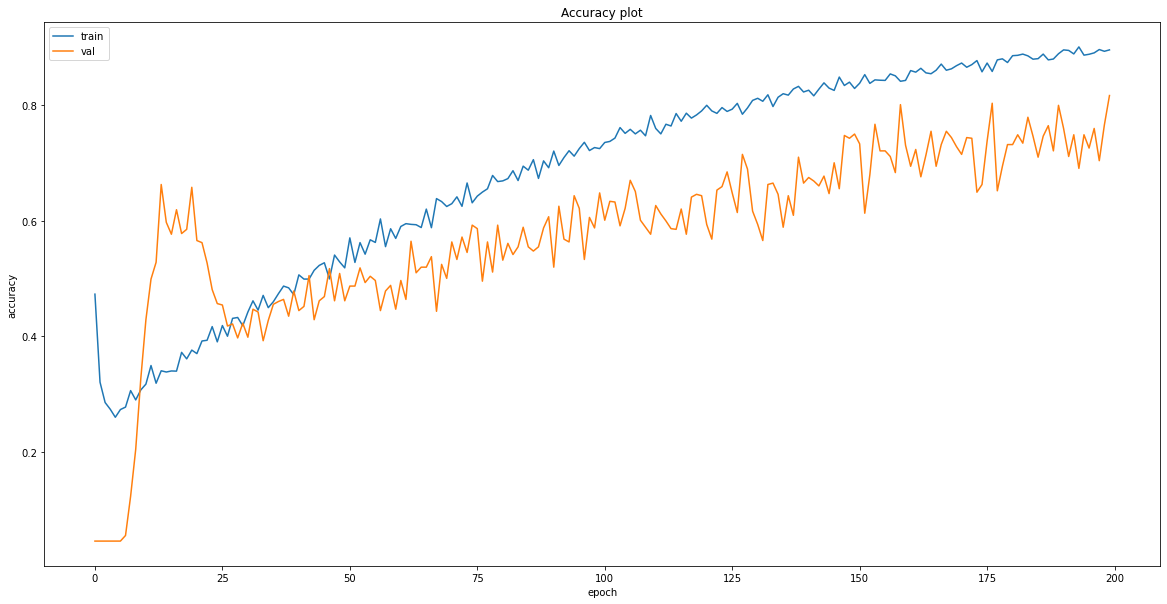

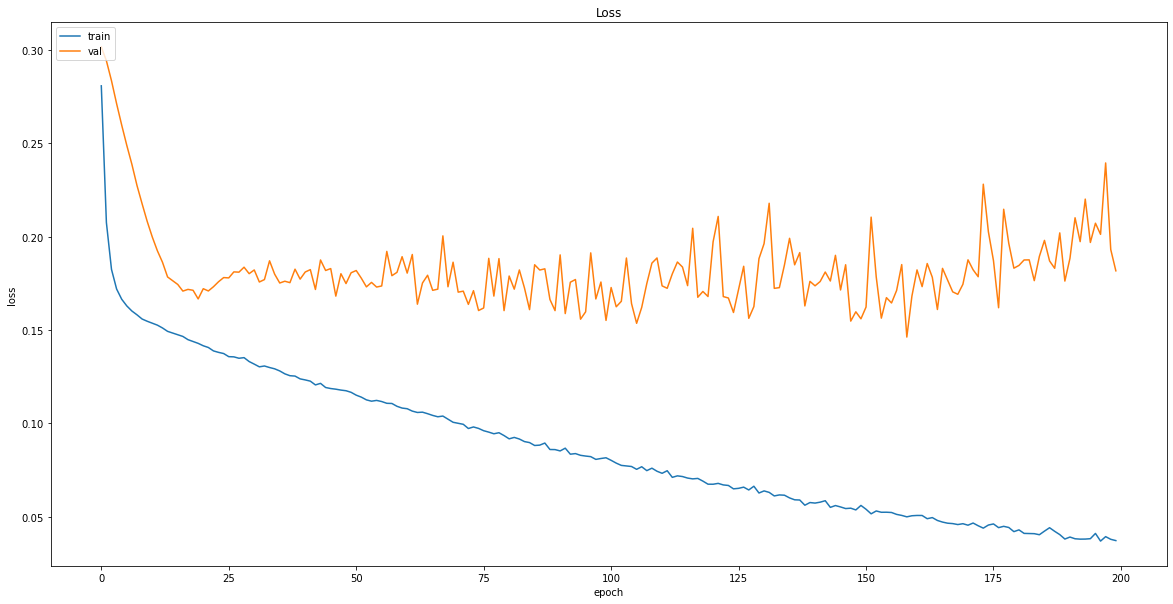

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
# Save model
model.save("models/{}".format('moutai_time_series_lstm_buy_hold_sell_5.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/moutai_time_series_lstm_buy_hold_sell_5.model\assets


### Test Performance

### non-recession

In [23]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test.csv")
df.set_index('Date', inplace=True)
df = df.iloc[10:]
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2019-02-12   725.299988  680.857339  -5.533611  42959323.0     2.0
2019-02-13   717.919983  686.559284 -15.712368  39450180.0     2.0
2019-02-14   735.250000  694.050163  -1.218823  43017886.0     2.0
2019-02-15   737.159973  700.682442  -8.071529  46243699.0     2.0
2019-02-18   724.780029  704.389763 -23.444619  43919901.0     2.0


In [24]:
labels = []
data_5 = []
sequential = []
count = 0

for i in df.values:
    if count == 4:
        data_5.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_arr = min_max_scaler.fit_transform(data_5)
        sequential.append(data_5_arr)
        data_5 = data_5[1:5]
    else:
        data_5.append(np.array(i[0:-1]))
        count+= 1

In [25]:
X = sequential
X  = np.array(X).reshape(-1, 5, 4)
y = labels
y = np.array(y)
X.shape

(207, 5, 4)

In [26]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [27]:
model = tf.keras.models.load_model("models/moutai_time_series_lstm_buy_hold_sell_5.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1777 - accuracy: 0.8116 - mean_squared_error: 7.7627 - weighted_accuracy: 0.8116 - weighted_mean_squared_error: 7.7627
Test loss: 0.17773841321468353
Test accuracy: 0.8115941882133484


In [28]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 182, 1: 10, 0: 15})

In [29]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 185, 0: 11, 1: 11})

In [30]:
df = df.iloc[4:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-18,740.00000,704.389763,-23.444619,43919901.0,2.0,2,2
2019-02-19,730.76001,709.868261,-6.049880,47694490.0,2.0,2,2
2019-02-20,722.00000,713.082376,-17.677836,44744340.0,2.0,2,2
2019-02-21,720.25000,714.454318,-29.824573,40956103.0,2.0,2,2
2019-02-22,726.01001,715.345962,-32.098776,37971063.0,2.0,2,2


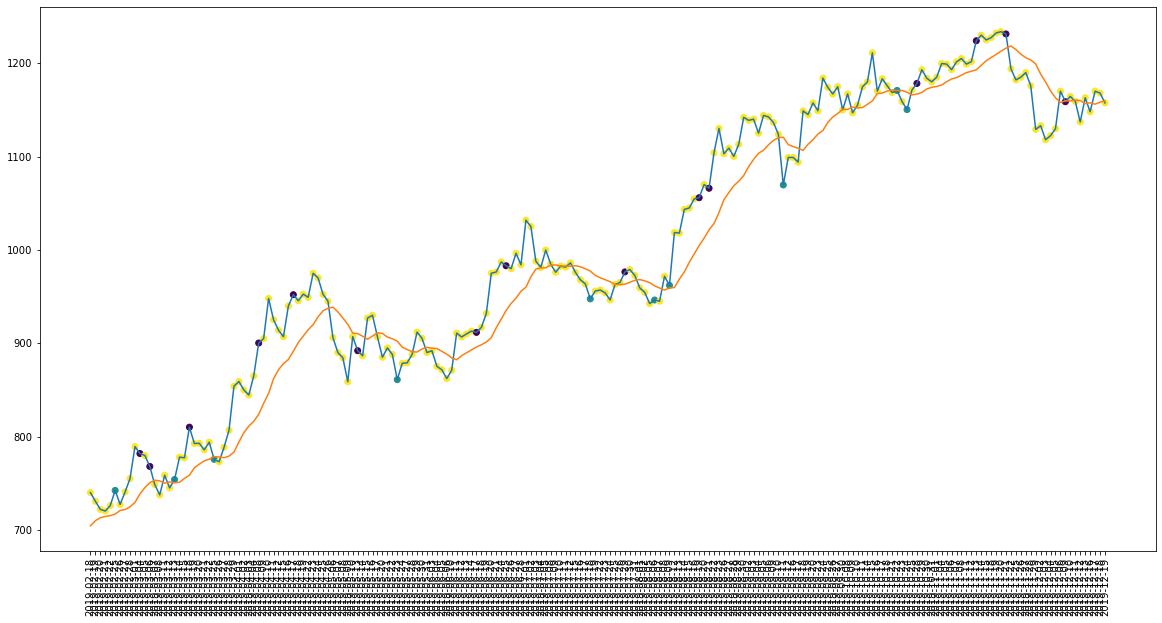

In [31]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [32]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 207
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 10
actual holds but predicted buy: 7
actual holds but predicted sell: 14
actual predicted holds: 164
Percentage buys correct: 27.272727272727273%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 88.64864864864865%
actual buys: 11
actual sells: 11
actual holds: 185


In [33]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[720.25, 722.0, 726.010009765625, 727.3499755859375, 730.760009765625, 740.0, 740.7000122070312, 742.3300170898438, 755.010009765625]
[727.3499755859375, 737.5, 740.7000122070312, 748.5999755859375, 755.010009765625, 768.0, 779.780029296875, 781.8599853515625, 789.2999877929688]
Percentage buys correct: 80.0%
Percentage sells correct: 40.0%
Percentage holds correct: 85.6353591160221%


In [34]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[720.25, 722.0, 726.010009765625, 727.3499755859375, 730.760009765625, 740.0, 740.7000122070312, 742.3300170898438, 755.010009765625]
[727.3499755859375, 737.5, 740.7000122070312, 748.5999755859375, 755.010009765625, 768.0, 779.780029296875, 781.8599853515625, 789.2999877929688]
Percentage buys correct: 80.0%
Percentage sells correct: 40.0%
Percentage holds correct: 85.6353591160221%


In [35]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $742.3300170898438
Shares owned at the moment: 13
Cash capital at the moment: $323.1714797210698


Price increase from previously bought: 5.036270801637954%
Share price: $781.8599853515625
Shares owned at the moment: 0
Cash capital at the moment: $10459.399794815063


Share price: $754.0
Shares owned at the moment: 13
Cash capital at the moment: $630.4442948150627


Price increase from previously bought: 7.144348645398724%
Share price: $810.0900268554688
Shares owned at the moment: 0
Cash capital at the moment: $11132.653925476074


Share price: $775.5999755859375
Shares owned at the moment: 14
Cash capital at the moment: $244.39366821288968


Price increase from previously bought: 15.746683796353445%
Share price: $900.2000122070312
Shares owned at the moment: 0
Cash capital at the moment: $12812.536138641357


Share price: $861.0
Shares owned at the moment: 14
Cash capital at the moment: $725.3876386413558


Price increase from previously bought: 5.586521570435954%
Share 

In [36]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $15358.36826651001
profit gained: 53.5836826651001%


### Recession

In [37]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test2.csv")
df.set_index('Date', inplace=True)
df = df.iloc[10:]
print(df.head())

            previous_1d       EMA_12   willr_14      OBV_7  labels
Date                                                              
2020-02-13  1097.270020  1076.474651 -15.554098  4904879.0     2.0
2020-02-14  1091.000000  1078.709320 -17.096133  1869143.0     2.0
2020-02-17  1088.000000  1080.138656 -19.336778  -459617.0     2.0
2020-02-18  1093.819946  1082.243470 -14.989967  2243205.0     2.0
2020-02-19  1084.000000  1082.513705 -22.324305  -423291.0     2.0


In [38]:
labels = []
data_5 = []
sequential = []
count = 0

for i in df.values:
    if count == 4:
        data_5.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_arr = min_max_scaler.fit_transform(data_5)
        sequential.append(data_5_arr)
        data_5 = data_5[1:5]
    else:
        data_5.append(np.array(i[0:-1]))
        count+= 1

In [39]:
X = sequential
X  = np.array(X).reshape(-1, 5, 4)
y = labels
y = np.array(y)
X.shape

(208, 5, 4)

In [40]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [41]:
model = tf.keras.models.load_model("models/moutai_time_series_lstm_buy_hold_sell_5.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1422 - accuracy: 0.8125 - mean_squared_error: 7.6590 - weighted_accuracy: 0.8125 - weighted_mean_squared_error: 7.6590
Test loss: 0.14219333231449127
Test accuracy: 0.8125


In [42]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 184, 0: 18, 1: 6})

In [43]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [44]:
df = df.iloc[4:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-19,1096.500000,1082.513705,-22.324305,-423291.0,2.0,2,2
2020-02-20,1118.000000,1084.665443,-12.988283,3281856.0,0.0,2,0
2020-02-21,1112.880005,1089.793836,-4.166667,7962118.0,2.0,0,2
2020-02-24,1087.180054,1093.345554,-10.201830,5068110.0,2.0,2,2
2020-02-25,1074.810059,1092.397016,-40.474836,1203074.0,2.0,2,2


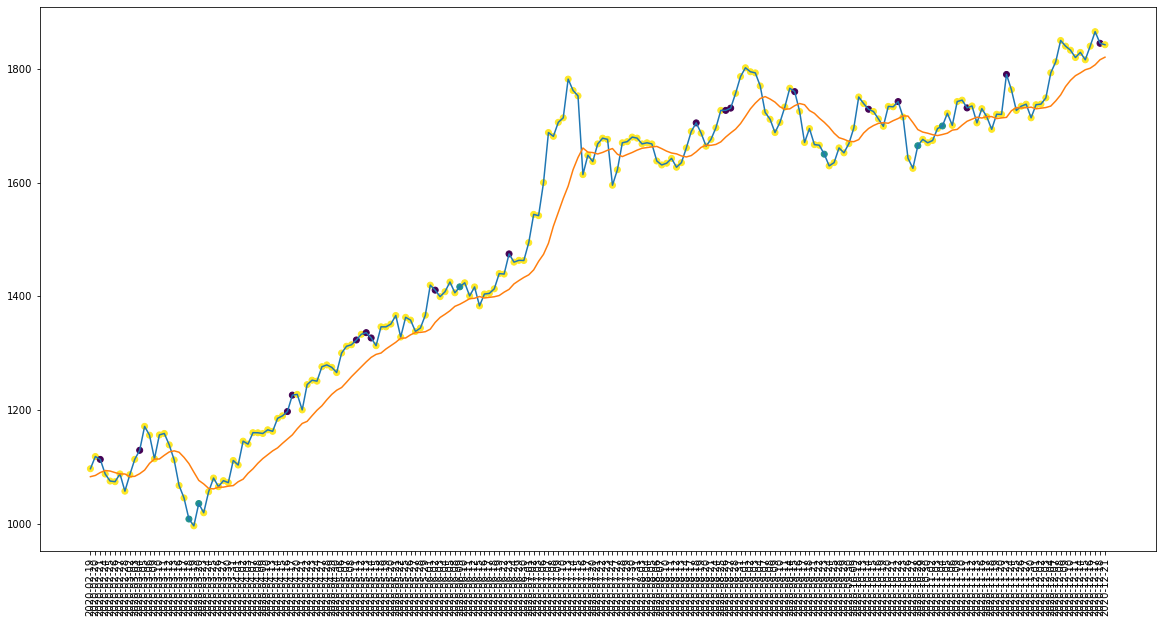

In [45]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [46]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 208
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 6
actual holds but predicted sell: 16
actual predicted holds: 167
Percentage buys correct: 0.0%
Percentage sells correct: 20.0%
Percentage holds correct: 88.35978835978835%
actual buys: 9
actual sells: 10
actual holds: 189


In [47]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[1057.0, 1073.699951171875, 1074.81005859375, 1086.010009765625, 1087.1800537109377, 1087.3900146484377, 1096.5, 1112.8800048828123, 1118.0]
[1057.0, 1086.010009765625, 1087.3900146484377, 1113.0, 1114.010009765625, 1128.9200439453125, 1155.5, 1156.0, 1171.0]
Percentage buys correct: 66.66666666666667%
Percentage sells correct: 77.77777777777777%
Percentage holds correct: 84.69945355191257%


In [48]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $1007.989990234375
Shares owned at the moment: 9
Cash capital at the moment: $903.1423356323248


Price increase from previously bought: 18.435400198408324%
Share price: $1197.0999755859375
Shares owned at the moment: 0
Cash capital at the moment: $11647.41389151001


Share price: $1416.550048828125
Shares owned at the moment: 8
Cash capital at the moment: $283.8493998107915


Price increase from previously bought: 20.03275917484919%
Share price: $1705.0
Shares owned at the moment: 0
Cash capital at the moment: $13886.339399810791


Share price: $1649.97998046875
Shares owned at the moment: 8
Cash capital at the moment: $650.199996490479


Price increase from previously bought: 5.317718220035683%
Share price: $1742.5
Shares owned at the moment: 0
Cash capital at the moment: $14551.864996490478


Share price: $1664.81005859375
Shares owned at the moment: 8
Cash capital at the moment: $1196.7587064514155


Price increase from previously bought: 7.237481877488761%
Share price

In [49]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $16641.259749999997
profit gained: 66.41259749999998%


### Midea Group

In [50]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14        OBV_7  labels
0  2013-10-17    11.912000  11.900182 -34.022038  235647532.0     1.0
1  2013-10-18    11.896000  11.899539 -39.103542  214825024.0     2.0
2  2013-10-21    12.269333  11.956430 -24.093825  253903732.0     2.0
3  2013-10-22    12.760000  12.080056  -4.424713  304775737.0     2.0
4  2013-10-23    12.645333  12.167022 -15.187657  273970459.0     2.0


In [51]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2013-10-17,11.912000,11.900182,-34.022038,235647532.0,1.0
2013-10-18,11.896000,11.899539,-39.103542,214825024.0,2.0
2013-10-21,12.269333,11.956430,-24.093825,253903732.0,2.0
2013-10-22,12.760000,12.080056,-4.424713,304775737.0,2.0
2013-10-23,12.645333,12.167022,-15.187657,273970459.0,2.0


In [52]:
labels = []
data_5 = []
sequential = []
count = 0

for i in df.values:
    if count == 4:
        data_5.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_arr = min_max_scaler.fit_transform(data_5)
        sequential.append(data_5_arr)
        data_5 = data_5[1:5]
    else:
        data_5.append(np.array(i[0:-1]))
        count+= 1

In [53]:
X = sequential
X  = np.array(X).reshape(-1, 5, 4)
X.shape

(1263, 5, 4)

In [54]:
y = labels
y = np.array(y)

In [55]:
X[0]

array([[0.01851827, 0.00240565, 0.14653045, 0.23148797],
       [0.        , 0.        , 0.        , 0.        ],
       [0.43209819, 0.2126914 , 0.43282076, 0.43444578],
       [1.        , 0.67487426, 1.        , 1.        ],
       [0.86728368, 1.        , 0.68963934, 0.65753159]])

In [56]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [57]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [58]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [59]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [60]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
8/8 [==============================] - 1s 94ms/step - loss: 0.3089 - accuracy: 0.4842 - mse: 0.3696 - weighted_accuracy: 0.2973 - weighted_mse: 0.4382 - val_loss: 0.3046 - val_accuracy: 0.0632 - val_mse: 0.3377 - val_weighted_accuracy: 0.0632 - val_weighted_mse: 0.3377
Epoch 2/200
8/8 [==============================] - 0s 7ms/step - loss: 0.2648 - accuracy: 0.4713 - mse: 0.4335 - weighted_accuracy: 0.4339 - weighted_mse: 0.4700 - val_loss: 0.3033 - val_accuracy: 0.0553 - val_mse: 0.3398 - val_weighted_accuracy: 0.0553 - val_weighted_mse: 0.3398
Epoch 3/200
8/8 [==============================] - 0s 7ms/step - loss: 0.2322 - accuracy: 0.4287 - mse: 0.5065 - weighted_accuracy: 0.4978 - weighted_mse: 0.5131 - val_loss: 0.3016 - val_accuracy: 0.0474 - val_mse: 0.3427 - val_weighted_accuracy: 0.0474 - val_weighted_mse: 0.3427
Epoch 4/200
8/8 [==============================] - 0s 8ms/step - loss: 0.2140 - accuracy: 0.3931 - mse: 0.5873 - weighted_accuracy: 0.5553 - weighted_mse: 0

8/8 [==============================] - 0s 6ms/step - loss: 0.1285 - accuracy: 0.4901 - mse: 1.5010 - weighted_accuracy: 0.7588 - weighted_mse: 1.4796 - val_loss: 0.2121 - val_accuracy: 0.2530 - val_mse: 0.5975 - val_weighted_accuracy: 0.2530 - val_weighted_mse: 0.5975
Epoch 31/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1268 - accuracy: 0.4743 - mse: 1.5209 - weighted_accuracy: 0.7530 - weighted_mse: 1.4924 - val_loss: 0.2087 - val_accuracy: 0.2925 - val_mse: 0.6140 - val_weighted_accuracy: 0.2925 - val_weighted_mse: 0.6140
Epoch 32/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1252 - accuracy: 0.4911 - mse: 1.5279 - weighted_accuracy: 0.7516 - weighted_mse: 1.5202 - val_loss: 0.2053 - val_accuracy: 0.3202 - val_mse: 0.6317 - val_weighted_accuracy: 0.3202 - val_weighted_mse: 0.6317
Epoch 33/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1248 - accuracy: 0.4960 - mse: 1.5343 - weighted_accuracy: 0.7534 - weighted_mse: 1.5199 - va

8/8 [==============================] - 0s 7ms/step - loss: 0.1017 - accuracy: 0.6208 - mse: 1.8231 - weighted_accuracy: 0.8256 - weighted_mse: 1.8365 - val_loss: 0.1434 - val_accuracy: 0.8024 - val_mse: 1.1684 - val_weighted_accuracy: 0.8024 - val_weighted_mse: 1.1684
Epoch 60/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1007 - accuracy: 0.6238 - mse: 1.8307 - weighted_accuracy: 0.8330 - weighted_mse: 1.8620 - val_loss: 0.1427 - val_accuracy: 0.7984 - val_mse: 1.1828 - val_weighted_accuracy: 0.7984 - val_weighted_mse: 1.1828
Epoch 61/200
8/8 [==============================] - 0s 6ms/step - loss: 0.1008 - accuracy: 0.6337 - mse: 1.8363 - weighted_accuracy: 0.8429 - weighted_mse: 1.8590 - val_loss: 0.1418 - val_accuracy: 0.8024 - val_mse: 1.2004 - val_weighted_accuracy: 0.8024 - val_weighted_mse: 1.2004
Epoch 62/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0997 - accuracy: 0.6257 - mse: 1.8595 - weighted_accuracy: 0.8476 - weighted_mse: 1.8704 - va

8/8 [==============================] - 0s 7ms/step - loss: 0.0792 - accuracy: 0.7545 - mse: 2.2446 - weighted_accuracy: 0.9099 - weighted_mse: 2.2550 - val_loss: 0.1442 - val_accuracy: 0.6759 - val_mse: 1.8038 - val_weighted_accuracy: 0.6759 - val_weighted_mse: 1.8038
Epoch 89/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0800 - accuracy: 0.7465 - mse: 2.2609 - weighted_accuracy: 0.9070 - weighted_mse: 2.2741 - val_loss: 0.1473 - val_accuracy: 0.6364 - val_mse: 1.8625 - val_weighted_accuracy: 0.6364 - val_weighted_mse: 1.8625
Epoch 90/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0789 - accuracy: 0.7277 - mse: 2.3021 - weighted_accuracy: 0.9001 - weighted_mse: 2.2967 - val_loss: 0.1544 - val_accuracy: 0.6126 - val_mse: 1.9277 - val_weighted_accuracy: 0.6126 - val_weighted_mse: 1.9277
Epoch 91/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0773 - accuracy: 0.7495 - mse: 2.3028 - weighted_accuracy: 0.9081 - weighted_mse: 2.3050 - va

8/8 [==============================] - 0s 7ms/step - loss: 0.0593 - accuracy: 0.8287 - mse: 2.8736 - weighted_accuracy: 0.9372 - weighted_mse: 2.8018 - val_loss: 0.1393 - val_accuracy: 0.7036 - val_mse: 2.6512 - val_weighted_accuracy: 0.7036 - val_weighted_mse: 2.6512
Epoch 118/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0595 - accuracy: 0.8297 - mse: 2.8932 - weighted_accuracy: 0.9375 - weighted_mse: 2.8306 - val_loss: 0.1512 - val_accuracy: 0.6680 - val_mse: 2.7520 - val_weighted_accuracy: 0.6680 - val_weighted_mse: 2.7520
Epoch 119/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0598 - accuracy: 0.8208 - mse: 2.9655 - weighted_accuracy: 0.9343 - weighted_mse: 2.8501 - val_loss: 0.1594 - val_accuracy: 0.6561 - val_mse: 2.9283 - val_weighted_accuracy: 0.6561 - val_weighted_mse: 2.9283
Epoch 120/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0578 - accuracy: 0.8208 - mse: 2.9950 - weighted_accuracy: 0.9343 - weighted_mse: 2.8986 -

Epoch 146/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0449 - accuracy: 0.8554 - mse: 3.8076 - weighted_accuracy: 0.9470 - weighted_mse: 3.5331 - val_loss: 0.1582 - val_accuracy: 0.7233 - val_mse: 3.6978 - val_weighted_accuracy: 0.7233 - val_weighted_mse: 3.6978
Epoch 147/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0441 - accuracy: 0.8802 - mse: 3.8675 - weighted_accuracy: 0.9561 - weighted_mse: 3.5296 - val_loss: 0.1505 - val_accuracy: 0.7747 - val_mse: 3.8392 - val_weighted_accuracy: 0.7747 - val_weighted_mse: 3.8392
Epoch 148/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0441 - accuracy: 0.8812 - mse: 3.9270 - weighted_accuracy: 0.9564 - weighted_mse: 3.5489 - val_loss: 0.1557 - val_accuracy: 0.7352 - val_mse: 3.9243 - val_weighted_accuracy: 0.7352 - val_weighted_mse: 3.9243
Epoch 149/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0424 - accuracy: 0.8832 - mse: 4.0074 - weighted_accuracy: 0.9572 - weighted

Epoch 175/200
8/8 [==============================] - 0s 6ms/step - loss: 0.0324 - accuracy: 0.9129 - mse: 5.0983 - weighted_accuracy: 0.9680 - weighted_mse: 4.3666 - val_loss: 0.1651 - val_accuracy: 0.7905 - val_mse: 5.3465 - val_weighted_accuracy: 0.7905 - val_weighted_mse: 5.3465
Epoch 176/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0320 - accuracy: 0.9178 - mse: 5.1220 - weighted_accuracy: 0.9699 - weighted_mse: 4.3491 - val_loss: 0.1646 - val_accuracy: 0.8024 - val_mse: 5.4160 - val_weighted_accuracy: 0.8024 - val_weighted_mse: 5.4160
Epoch 177/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0299 - accuracy: 0.9337 - mse: 5.2010 - weighted_accuracy: 0.9757 - weighted_mse: 4.4732 - val_loss: 0.1674 - val_accuracy: 0.8063 - val_mse: 5.4606 - val_weighted_accuracy: 0.8063 - val_weighted_mse: 5.4606
Epoch 178/200
8/8 [==============================] - 0s 6ms/step - loss: 0.0308 - accuracy: 0.9208 - mse: 5.2325 - weighted_accuracy: 0.9710 - weighted

In [61]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.18753087520599365
Test accuracy: 0.8063241243362427


In [62]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-3.75426078e+00 -7.44869411e-01  6.75903082e-01]
 [-2.54658175e+00 -8.50028694e-01 -1.60212129e-01]
 [-2.96925592e+00  6.72370255e-01 -1.54485488e+00]
 [-3.64430761e+00 -3.41490078e+00  3.38351536e+00]
 [-3.49582434e+00 -1.05120707e+00  1.20655894e+00]
 [-2.45759296e+00 -1.58032775e-03 -6.65126383e-01]
 [-3.37943530e+00 -8.80150139e-01  4.25665453e-02]
 [-2.61419988e+00 -1.35826039e+00  1.01851761e+00]
 [-2.30473375e+00 -1.81453273e-01 -1.28408980e+00]
 [-4.17613220e+00 -8.49778414e-01  5.17965972e-01]
 [-3.55064106e+00 -3.90910244e+00  4.64280605e+00]
 [-4.33064127e+00  3.56951058e-01  3.48173469e-01]
 [-9.84953761e-01 -4.02217293e+00  5.50352752e-01]
 [-9.30612087e-01 -3.65407228e+00  5.36600471e-01]
 [-3.22180748e+00 -5.26223838e-01  4.37832624e-03]
 [-1.93212533e+00 -3.94333076e+00  2.28891540e+00]
 [-2.22433352e+00  3.22860181e-01 -1.10984993e+00]
 [-4.73976421e+00 -4.09621096e+00  4.49631405e+00]
 [-1.71496797e+00 -3.21063423e+00  1.36474347e+00]
 [-1.99493337e+00 -2.79883504e+

Counter({2: 222, 1: 28, 0: 3})

In [63]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 230, 1: 12, 0: 11})

In [64]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 253
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 10
actual holds but predicted buy: 25
actual holds but predicted sell: 3
actual predicted holds: 202
Percentage buys correct: 16.666666666666668%
Percentage sells correct: 0.0%
Percentage holds correct: 87.82608695652173%
actual buys: 12
actual sells: 11
actual holds: 230


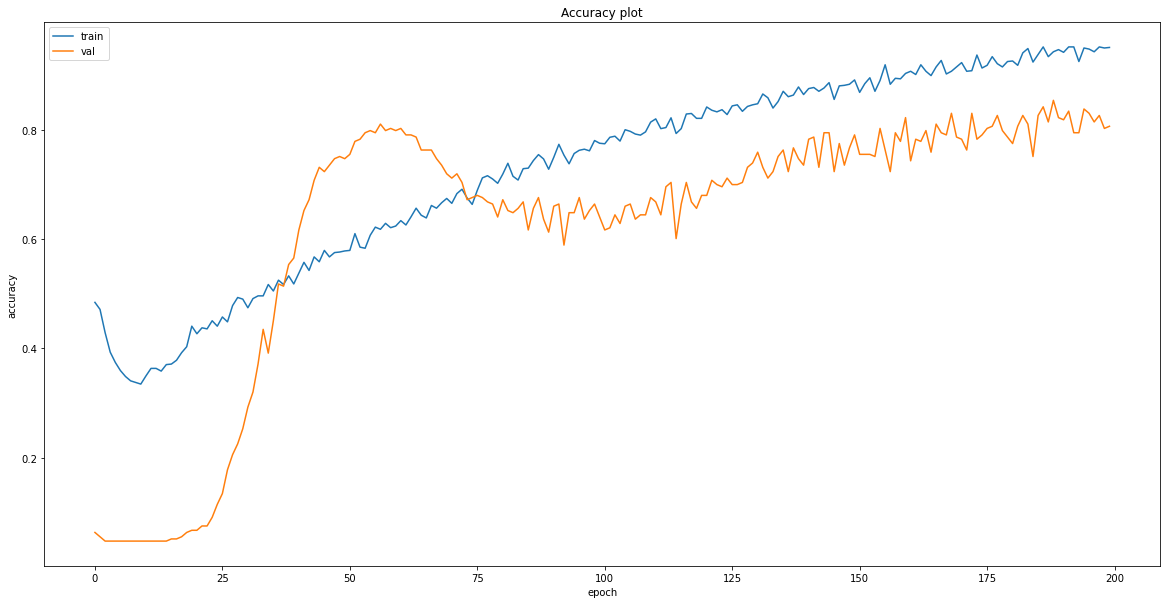

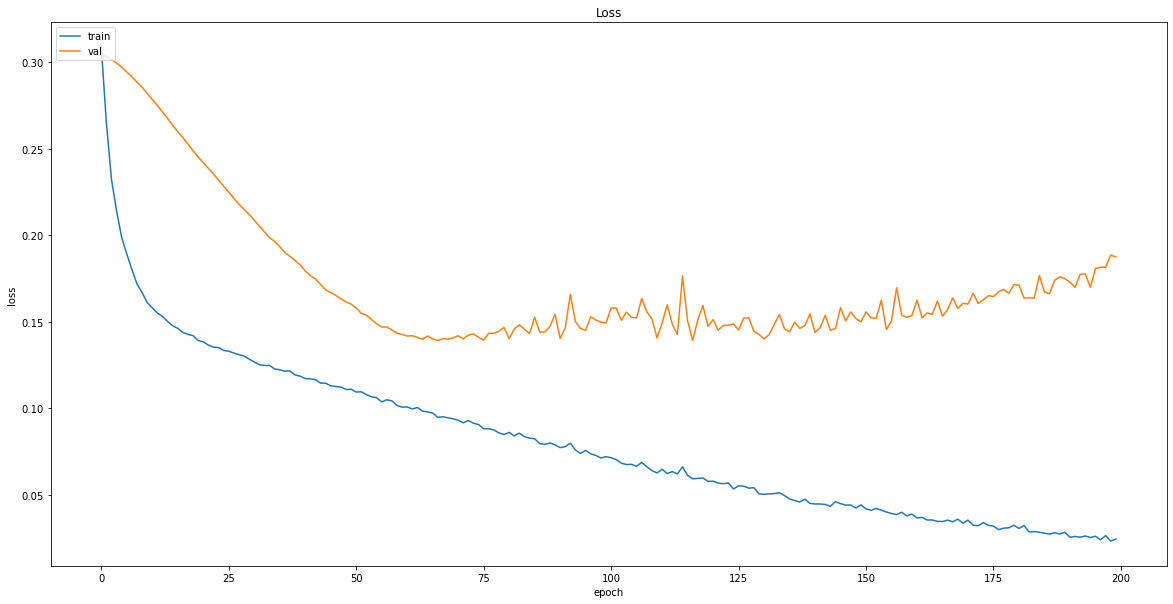

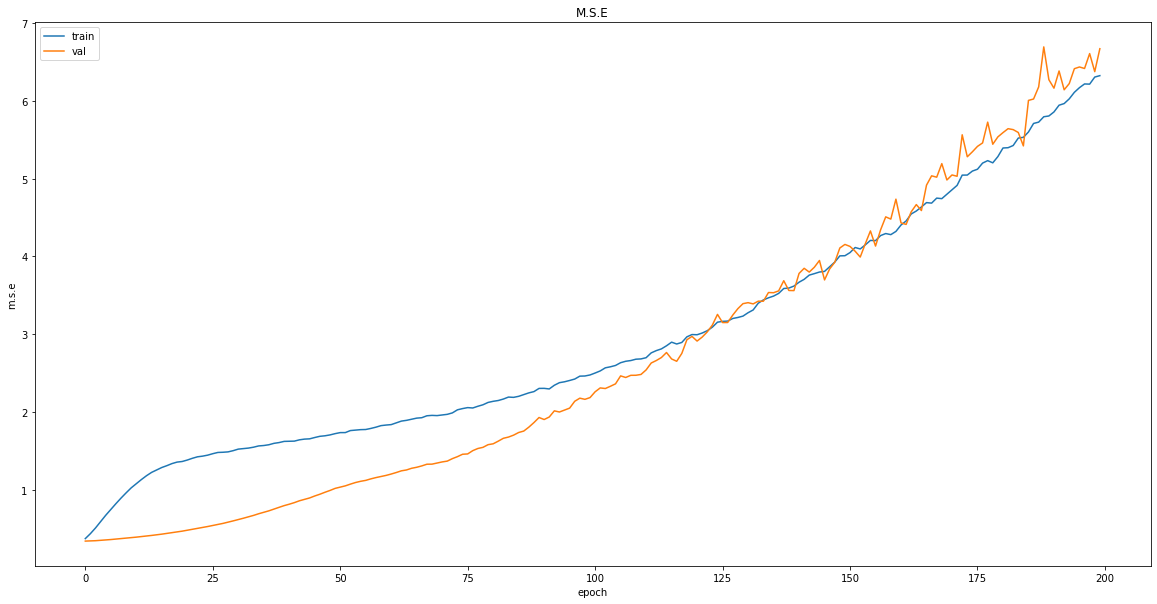

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('M.S.E')
plt.ylabel('m.s.e')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [66]:
# Save model
model.save("models/{}".format('midea_time_series_lstm_buy_hold_sell_5.model'))

INFO:tensorflow:Assets written to: models/midea_time_series_lstm_buy_hold_sell_5.model\assets


### Test Performance

### non-recession

In [67]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test.csv")
df.set_index('Date', inplace=True)
df = df.iloc[10:]
print(df.head())

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-02-12    46.080002  42.654367  -4.210488  380829366.0     2.0
2019-02-13    46.490002  43.244464  -6.612900  411118769.0     2.0
2019-02-14    46.799999  43.791470  -6.584998  443533043.0     2.0
2019-02-15    47.150002  44.308167  -2.420572  466454440.0     2.0
2019-02-18    45.270000  44.456141 -30.862341  419918481.0     2.0


In [68]:
labels = []
data_5 = []
sequential = []
count = 0

for i in df.values:
    if count == 4:
        data_5.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_arr = min_max_scaler.fit_transform(data_5)
        sequential.append(data_5_arr)
        data_5 = data_5[1:5]
    else:
        data_5.append(np.array(i[0:-1]))
        count+= 1

In [69]:
X = sequential
X  = np.array(X).reshape(-1, 5, 4)
y = labels
y = np.array(y)
X.shape

(207, 5, 4)

In [70]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [71]:
model = tf.keras.models.load_model("models/midea_time_series_lstm_buy_hold_sell_5.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2347 - accuracy: 0.7971 - mean_squared_error: 7.2358 - weighted_accuracy: 0.7971 - weighted_mean_squared_error: 7.2358
Test loss: 0.23471279442310333
Test accuracy: 0.7971014380455017


In [72]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 182, 0: 8, 1: 17})

In [73]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 186, 0: 10, 1: 11})

In [74]:
df = df.iloc[4:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-18,46.400002,44.456141,-30.862341,419918481.0,2.0,2,2
2019-02-19,46.080002,44.755197,-13.767016,452488699.0,2.0,2,2
2019-02-20,46.080002,44.959013,-18.975880,424412835.0,2.0,2,2
2019-02-21,45.860001,45.131473,-18.975880,424412835.0,2.0,2,2
2019-02-22,45.610001,45.243554,-26.174460,382970560.0,2.0,2,2


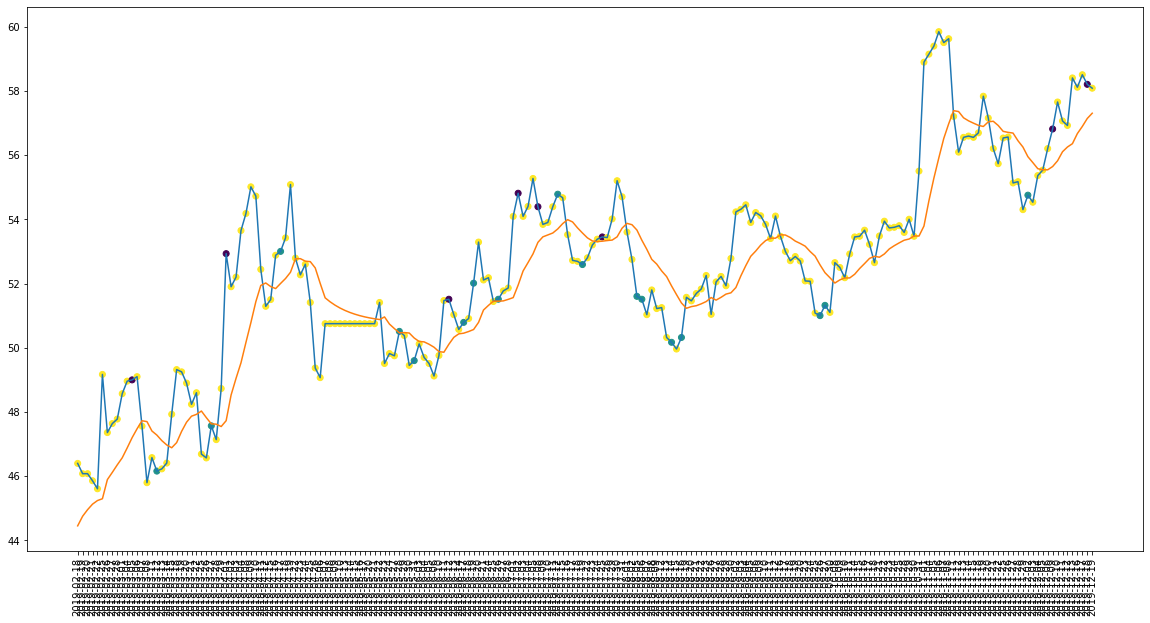

In [75]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

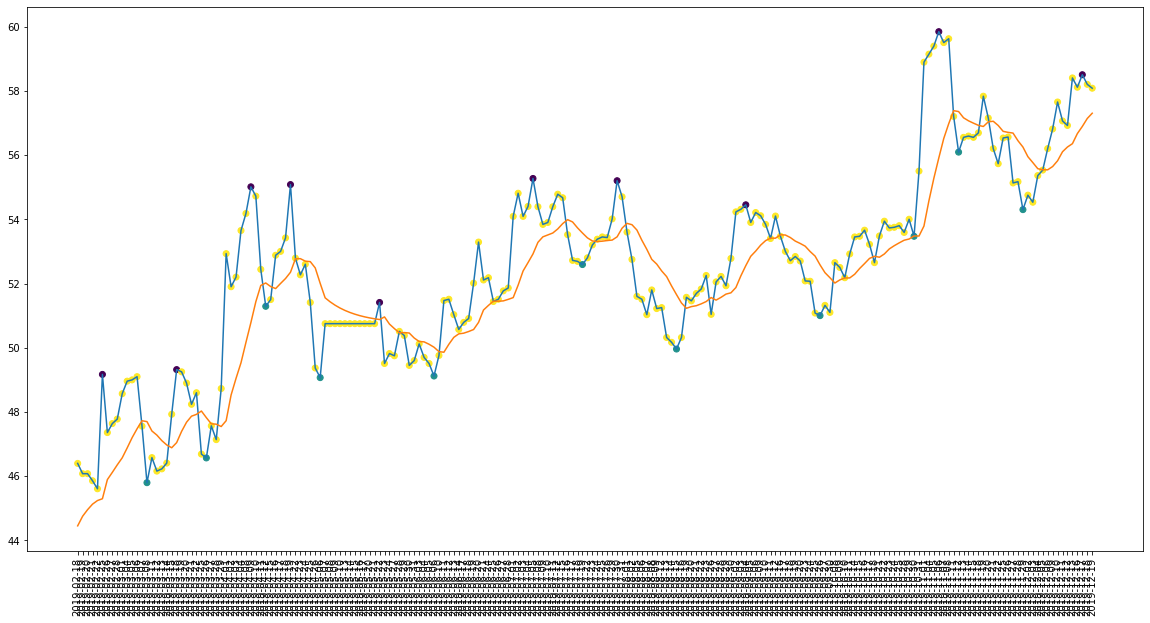

In [76]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [77]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 207
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 10
actual holds but predicted buy: 15
actual holds but predicted sell: 8
actual predicted holds: 163
Percentage buys correct: 18.181818181818183%
Percentage sells correct: 0.0%
Percentage holds correct: 87.63440860215054%
actual buys: 11
actual sells: 10
actual holds: 186


In [78]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[45.61000061035156, 45.86000061035156, 46.08000183105469, 46.08000183105469, 46.4000015258789, 47.36000061035156, 47.63999938964844, 47.77999877929688, 49.16999816894531]
[45.79999923706055, 47.36000061035156, 47.56000137329102, 47.63999938964844, 47.77999877929688, 48.56999969482422, 48.959999084472656, 49.0, 49.099998474121094]
Percentage buys correct: 76.47058823529412%
Percentage sells correct: 75.0%
Percentage holds correct: 79.00552486187846%


In [79]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $46.15999984741211
Shares owned at the moment: 216
Cash capital at the moment: $2.0209930496221205


Price increase from previously bought: 14.351911100934277%
Share price: $52.93000030517578
Shares owned at the moment: 0
Cash capital at the moment: $11403.460638786317


Share price: $53.0
Shares owned at the moment: 214
Cash capital at the moment: $30.270138786316238


Stop Loss Activated!

Share price: $51.40999984741211
Shares owned at the moment: 0
Cash capital at the moment: $11001.755321222305


Share price: $50.5099983215332
Shares owned at the moment: 217
Cash capital at the moment: $10.943843951225062


Stop Loss Activated!

Share price: $49.11999893188477
Shares owned at the moment: 0
Cash capital at the moment: $10640.671252807619


Share price: $50.790000915527344
Shares owned at the moment: 208
Cash capital at the moment: $47.29918185424867


Price increase from previously bought: 7.618992416061965%
Share price: $54.81000137329102
Shares owned at the moment: 0

In [80]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12438.033583332062
profit gained: 24.380335833320625%


### recession

In [81]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test2.csv")
df = df.iloc[10:]
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-02-13    54.889999  54.718954 -53.549524  20343150.0     2.0
2020-02-14    53.799999  54.577577 -63.102549 -11587509.0     2.0
2020-02-17    53.740002  54.448719 -63.500423 -32591896.0     2.0
2020-02-18    54.400002  54.441224 -52.704009    -86645.0     2.0
2020-02-19    53.529999  54.301035 -52.927131 -33290149.0     2.0


In [82]:
labels = []
data_5 = []
sequential = []
count = 0

for i in df.values:
    if count == 4:
        data_5.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_arr = min_max_scaler.fit_transform(data_5)
        sequential.append(data_5_arr)
        data_5 = data_5[1:5]
    else:
        data_5.append(np.array(i[0:-1]))
        count+= 1

In [83]:
X = sequential
X  = np.array(X).reshape(-1, 5, 4)
y = labels
y = np.array(y)
X.shape

(208, 5, 4)

In [84]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [85]:
model = tf.keras.models.load_model("models/midea_time_series_lstm_buy_hold_sell_5.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 2ms/step - loss: 0.1562 - accuracy: 0.8462 - mean_squared_error: 5.9930 - weighted_accuracy: 0.8462 - weighted_mean_squared_error: 5.9930
Test loss: 0.15621797740459442
Test accuracy: 0.8461538553237915


In [86]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 185, 1: 17, 0: 6})

In [87]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 193, 0: 8, 1: 7})

In [88]:
df = df.iloc[4:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-19,53.540001,54.301035,-52.927131,-33290149.0,2.0,2,2
2020-02-20,54.860001,54.183953,-44.755246,-9557295.0,2.0,2,2
2020-02-21,54.279999,54.287960,-8.665511,27483857.0,2.0,2,2
2020-02-24,54.910000,54.286736,-21.343904,-2296012.0,0.0,2,0
2020-02-25,54.430000,54.382622,-12.602723,38486402.0,2.0,2,2


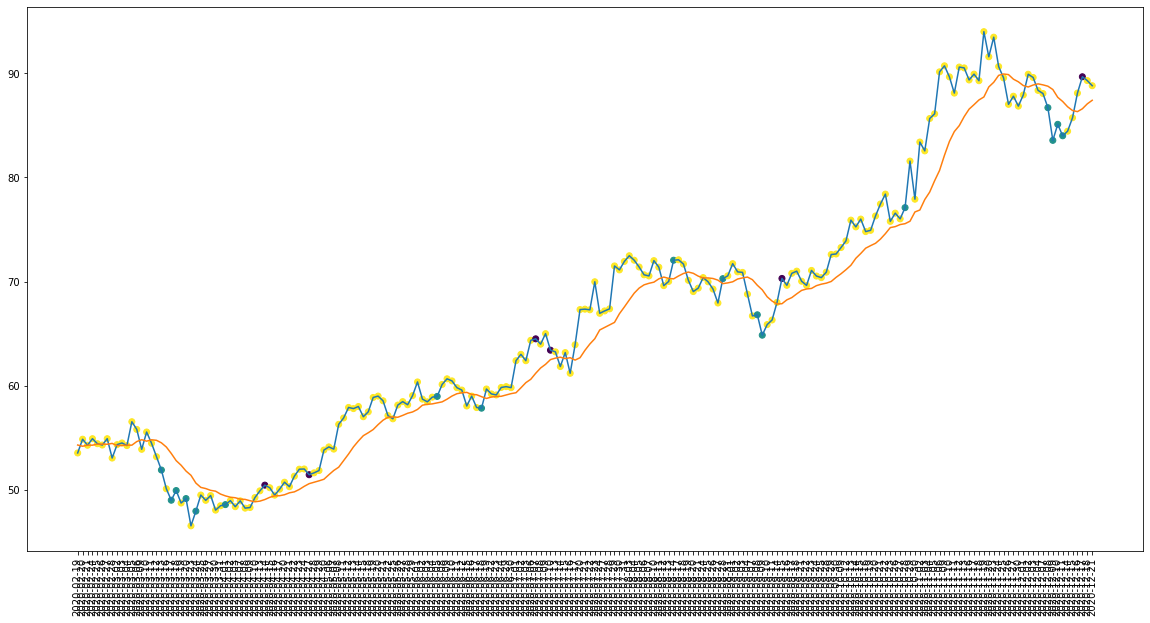

In [89]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

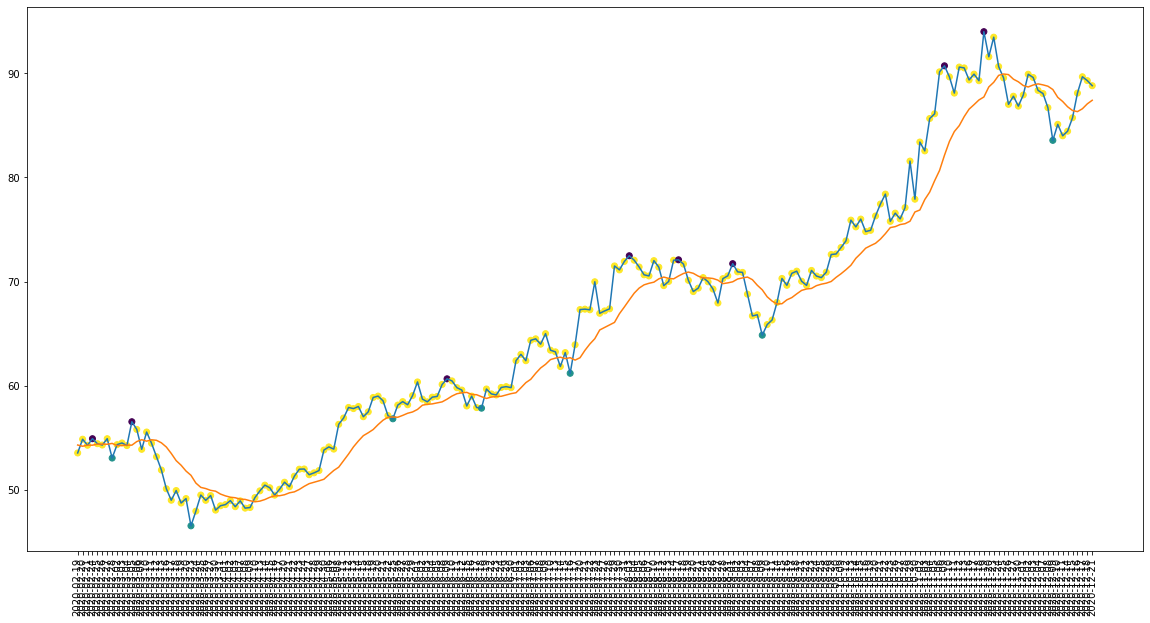

In [90]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [91]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 208
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 8
actual holds but predicted buy: 14
actual holds but predicted sell: 6
actual predicted holds: 173
Percentage buys correct: 42.857142857142854%
Percentage sells correct: 0.0%
Percentage holds correct: 89.63730569948187%
actual buys: 7
actual sells: 8
actual holds: 193


In [92]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[53.04999923706055, 53.540000915527344, 54.27999877929688, 54.29999923706055, 54.34000015258789, 54.43000030517578, 54.86000061035156, 54.90999984741211, 54.90999984741211]
[53.04999923706055, 53.88999938964844, 54.25, 54.34000015258789, 54.5, 54.90999984741211, 55.54999923706055, 55.79999923706055, 56.540000915527344]
Percentage buys correct: 58.8235294117647%
Percentage sells correct: 66.66666666666667%
Percentage holds correct: 85.8695652173913%


In [93]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $51.9000015258789
Shares owned at the moment: 192
Cash capital at the moment: $7.796506225588018


Stop Loss Activated!

Share price: $50.099998474121094
Shares owned at the moment: 0
Cash capital at the moment: $9600.543414062502


Share price: $49.0
Shares owned at the moment: 195
Cash capital at the moment: $19.26716406250125


Stop Loss Activated!

Share price: $46.540000915527344
Shares owned at the moment: 0
Cash capital at the moment: $9069.610267099382


Share price: $47.95000076293945
Shares owned at the moment: 188
Cash capital at the moment: $30.21997327232566


Price increase from previously bought: 7.005006189830909%
Share price: $51.45000076293945
Shares owned at the moment: 0
Cash capital at the moment: $9676.220466310502


Share price: $58.97000122070313
Shares owned at the moment: 163
Cash capital at the moment: $37.676964288710224


Price increase from previously bought: 9.077683757869416%
Share price: $64.5
Shares owned at the moment: 0
Cash capital at t

In [94]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $16487.407351390837
profit gained: 64.87407351390837%


## Walmart

In [95]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14       OBV_7  labels
0  2000-01-21      63.3750  65.176128 -85.271318 -26649200.0     2.0
1  2000-01-24      62.4375  64.754801 -94.594595 -33601700.0     2.0
2  2000-01-25      59.3750  63.927139 -83.606557 -41401600.0     2.0
3  2000-01-26      61.1250  63.496041 -68.306011 -34997800.0     2.0
4  2000-01-27      61.9375  63.256265 -61.202186 -30459400.0     2.0


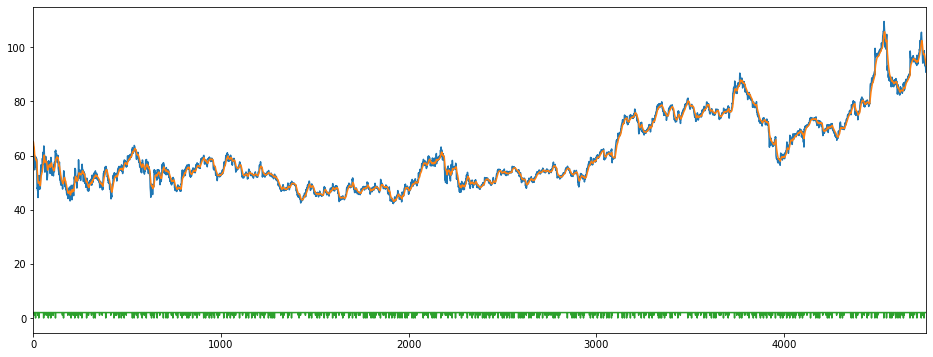

In [96]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [97]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,63.3750,65.176128,-85.271318,-26649200.0,2.0
2000-01-24,62.4375,64.754801,-94.594595,-33601700.0,2.0
2000-01-25,59.3750,63.927139,-83.606557,-41401600.0,2.0
2000-01-26,61.1250,63.496041,-68.306011,-34997800.0,2.0
2000-01-27,61.9375,63.256265,-61.202186,-30459400.0,2.0


In [98]:
labels = []
data_5 = []
sequential = []
count = 0

for i in df.values:
    if count == 4:
        data_5.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_arr = min_max_scaler.fit_transform(data_5)
        sequential.append(data_5_arr)
        data_5 = data_5[1:5]
    else:
        data_5.append(np.array(i[0:-1]))
        count+= 1

In [99]:
X = sequential
X  = np.array(X).reshape(-1, 5, 4)
X.shape

(4755, 5, 4)

In [100]:
y = labels
y = np.array(y)

In [101]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [102]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [103]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [104]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [105]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 1 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 28ms/step - loss: 0.2700 - accuracy: 0.4537 - mse: 0.4596 - weighted_accuracy: 0.4073 - weighted_mse: 0.4865 - val_loss: 0.3002 - val_accuracy: 0.0452 - val_mse: 0.3465 - val_weighted_accuracy: 0.0452 - val_weighted_mse: 0.3465
Epoch 2/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1983 - accuracy: 0.2942 - mse: 0.7863 - weighted_accuracy: 0.5485 - weighted_mse: 0.7349 - val_loss: 0.2903 - val_accuracy: 0.0452 - val_mse: 0.3666 - val_weighted_accuracy: 0.0452 - val_weighted_mse: 0.3666
Epoch 3/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1772 - accuracy: 0.2463 - mse: 1.0630 - weighted_accuracy: 0.5686 - weighted_mse: 0.9886 - val_loss: 0.2767 - val_accuracy: 0.0452 - val_mse: 0.3913 - val_weighted_accuracy: 0.0452 - val_weighted_mse: 0.3913
Epoch 4/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1677 - accuracy: 0.2421 - mse: 1.2523 - weighted_accuracy: 0.5850 - weighte

Epoch 30/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1317 - accuracy: 0.4243 - mse: 1.7865 - weighted_accuracy: 0.7185 - weighted_mse: 1.7327 - val_loss: 0.1935 - val_accuracy: 0.3596 - val_mse: 1.7617 - val_weighted_accuracy: 0.3596 - val_weighted_mse: 1.7617
Epoch 31/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1312 - accuracy: 0.4430 - mse: 1.7837 - weighted_accuracy: 0.7307 - weighted_mse: 1.7367 - val_loss: 0.1902 - val_accuracy: 0.3764 - val_mse: 1.7999 - val_weighted_accuracy: 0.3764 - val_weighted_mse: 1.7999
Epoch 32/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1308 - accuracy: 0.4366 - mse: 1.8264 - weighted_accuracy: 0.7320 - weighted_mse: 1.7880 - val_loss: 0.1938 - val_accuracy: 0.3617 - val_mse: 1.8247 - val_weighted_accuracy: 0.3617 - val_weighted_mse: 1.8247
Epoch 33/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1293 - accuracy: 0.4603 - mse: 1.8373 - weighted_accuracy: 0.7389 - weig

Epoch 59/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1094 - accuracy: 0.5610 - mse: 2.2699 - weighted_accuracy: 0.7957 - weighted_mse: 2.2411 - val_loss: 0.1850 - val_accuracy: 0.4742 - val_mse: 2.4129 - val_weighted_accuracy: 0.4742 - val_weighted_mse: 2.4129
Epoch 60/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1100 - accuracy: 0.5741 - mse: 2.2201 - weighted_accuracy: 0.8022 - weighted_mse: 2.1702 - val_loss: 0.1747 - val_accuracy: 0.5121 - val_mse: 2.3216 - val_weighted_accuracy: 0.5121 - val_weighted_mse: 2.3216
Epoch 61/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1082 - accuracy: 0.5910 - mse: 2.2498 - weighted_accuracy: 0.8138 - weighted_mse: 2.1997 - val_loss: 0.1716 - val_accuracy: 0.5142 - val_mse: 2.2996 - val_weighted_accuracy: 0.5142 - val_weighted_mse: 2.2996
Epoch 62/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1069 - accuracy: 0.6025 - mse: 2.3075 - weighted_accuracy: 0.8217 - weig

30/30 [==============================] - 0s 6ms/step - loss: 0.0892 - accuracy: 0.6690 - mse: 2.9149 - weighted_accuracy: 0.8605 - weighted_mse: 2.8393 - val_loss: 0.1764 - val_accuracy: 0.5594 - val_mse: 3.0095 - val_weighted_accuracy: 0.5594 - val_weighted_mse: 3.0095
Epoch 88/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0901 - accuracy: 0.6924 - mse: 2.9641 - weighted_accuracy: 0.8512 - weighted_mse: 2.8836 - val_loss: 0.2153 - val_accuracy: 0.4437 - val_mse: 3.1486 - val_weighted_accuracy: 0.4437 - val_weighted_mse: 3.1486
Epoch 89/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0890 - accuracy: 0.6548 - mse: 2.9716 - weighted_accuracy: 0.8517 - weighted_mse: 2.8767 - val_loss: 0.1810 - val_accuracy: 0.5478 - val_mse: 2.9731 - val_weighted_accuracy: 0.5478 - val_weighted_mse: 2.9731
Epoch 90/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0876 - accuracy: 0.6951 - mse: 3.0314 - weighted_accuracy: 0.8612 - weighted_mse: 2.9

Epoch 116/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0728 - accuracy: 0.7618 - mse: 3.9461 - weighted_accuracy: 0.8928 - weighted_mse: 3.7460 - val_loss: 0.1912 - val_accuracy: 0.6015 - val_mse: 4.1916 - val_weighted_accuracy: 0.6015 - val_weighted_mse: 4.1916
Epoch 117/200
30/30 [==============================] - 0s 5ms/step - loss: 0.0723 - accuracy: 0.7610 - mse: 3.8962 - weighted_accuracy: 0.8943 - weighted_mse: 3.6699 - val_loss: 0.1895 - val_accuracy: 0.5804 - val_mse: 3.9477 - val_weighted_accuracy: 0.5804 - val_weighted_mse: 3.9477
Epoch 118/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0709 - accuracy: 0.7655 - mse: 3.9704 - weighted_accuracy: 0.8941 - weighted_mse: 3.7473 - val_loss: 0.1706 - val_accuracy: 0.6551 - val_mse: 4.2595 - val_weighted_accuracy: 0.6551 - val_weighted_mse: 4.2595
Epoch 119/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0731 - accuracy: 0.7497 - mse: 3.9698 - weighted_accuracy: 0.8921 - 

Epoch 145/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0622 - accuracy: 0.8107 - mse: 5.0973 - weighted_accuracy: 0.9125 - weighted_mse: 4.6542 - val_loss: 0.1974 - val_accuracy: 0.6362 - val_mse: 5.6870 - val_weighted_accuracy: 0.6362 - val_weighted_mse: 5.6870
Epoch 146/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0597 - accuracy: 0.7960 - mse: 5.1901 - weighted_accuracy: 0.9125 - weighted_mse: 4.7514 - val_loss: 0.1934 - val_accuracy: 0.6551 - val_mse: 5.0914 - val_weighted_accuracy: 0.6551 - val_weighted_mse: 5.0914
Epoch 147/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0582 - accuracy: 0.8218 - mse: 5.1934 - weighted_accuracy: 0.9256 - weighted_mse: 4.6939 - val_loss: 0.1970 - val_accuracy: 0.6372 - val_mse: 5.1996 - val_weighted_accuracy: 0.6372 - val_weighted_mse: 5.1996
Epoch 148/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0563 - accuracy: 0.8160 - mse: 5.2615 - weighted_accuracy: 0.9271 - 

Epoch 174/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0494 - accuracy: 0.8499 - mse: 6.6095 - weighted_accuracy: 0.9322 - weighted_mse: 5.7311 - val_loss: 0.2068 - val_accuracy: 0.6951 - val_mse: 6.9573 - val_weighted_accuracy: 0.6951 - val_weighted_mse: 6.9573
Epoch 175/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0466 - accuracy: 0.8588 - mse: 6.7405 - weighted_accuracy: 0.9392 - weighted_mse: 5.9366 - val_loss: 0.2080 - val_accuracy: 0.7150 - val_mse: 7.0854 - val_weighted_accuracy: 0.7150 - val_weighted_mse: 7.0854
Epoch 176/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0464 - accuracy: 0.8678 - mse: 7.0240 - weighted_accuracy: 0.9478 - weighted_mse: 6.1122 - val_loss: 0.2236 - val_accuracy: 0.6467 - val_mse: 7.4772 - val_weighted_accuracy: 0.6467 - val_weighted_mse: 7.4772
Epoch 177/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0475 - accuracy: 0.8528 - mse: 6.9029 - weighted_accuracy: 0.9352 - 

In [106]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.21581000089645386
Test accuracy: 0.7413249015808105


In [107]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-2.7477815  -6.184763    2.5603542 ]
 [-4.3949056  -2.7887611   2.5361876 ]
 [-0.94791013 -5.238654    0.45695293]
 ...
 [-0.97224194 -5.9020853   0.09867781]
 [-4.9132223  -2.7762601   2.3783405 ]
 [-2.5571244  -3.1599739   1.8889722 ]]


Counter({2: 773, 1: 74, 0: 104})

In [108]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 864, 0: 44, 1: 43})

In [109]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 951
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 38
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 39
actual holds but predicted buy: 70
actual holds but predicted sell: 98
actual predicted holds: 696
Percentage buys correct: 9.30232558139535%
Percentage sells correct: 11.363636363636363%
Percentage holds correct: 80.55555555555556%
actual buys: 43
actual sells: 44
actual holds: 864


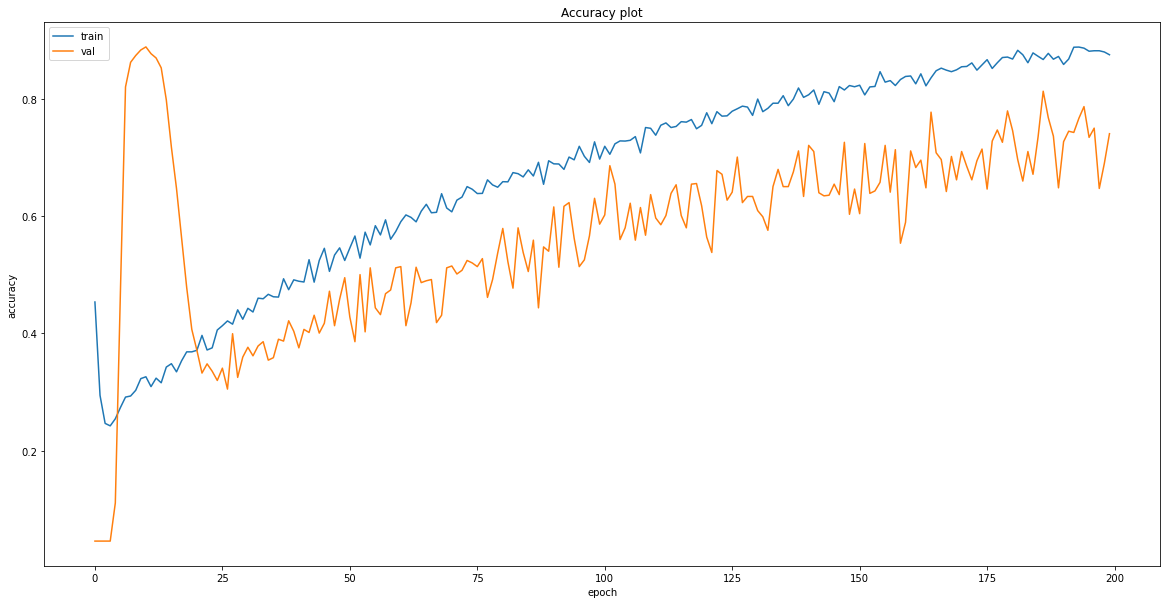

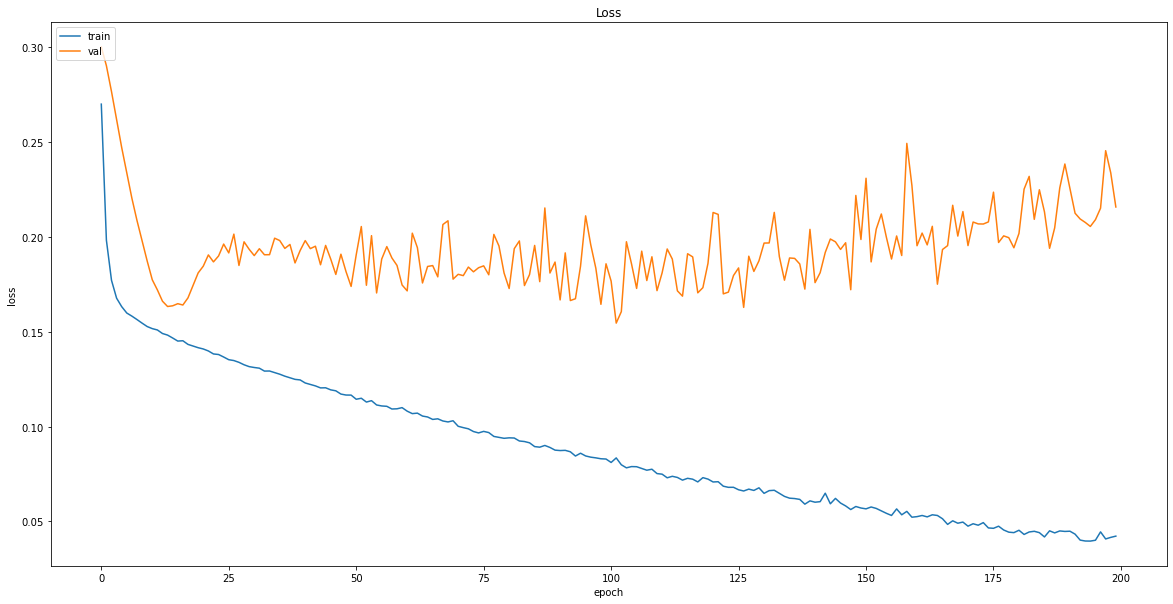

In [110]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [111]:
# Save model
model.save("models/{}".format('wmt_time_series_lstm_buy_hold_sell_5.model'))

INFO:tensorflow:Assets written to: models/wmt_time_series_lstm_buy_hold_sell_5.model\assets


### Test Performance

### non-recession

In [112]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test.csv")
df.set_index('Date', inplace=True)
df = df.iloc[10:]
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-02-05,94.769997,95.729495,-73.397490,42546200.0,2.0
2019-02-06,95.599998,95.709573,-60.096174,48646100.0,2.0
2019-02-07,95.639999,95.698869,-59.455134,52911000.0,2.0
2019-02-08,96.730003,95.857505,-41.987116,59921100.0,2.0
2019-02-11,95.580002,95.814812,-60.416634,53751900.0,2.0


In [113]:
labels = []
data_5 = []
sequential = []
count = 0

for i in df.values:
    if count == 4:
        data_5.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_arr = min_max_scaler.fit_transform(data_5)
        sequential.append(data_5_arr)
        data_5 = data_5[1:5]
    else:
        data_5.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 5, 4)
y = labels
y = np.array(y)
X.shape

(218, 5, 4)

In [114]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [115]:
model = tf.keras.models.load_model("models/wmt_time_series_lstm_buy_hold_sell_5.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 2ms/step - loss: 0.2285 - accuracy: 0.7156 - mean_squared_error: 9.6547 - weighted_accuracy: 0.7156 - weighted_mean_squared_error: 9.6547
Test loss: 0.22849182784557343
Test accuracy: 0.7155963182449341


In [116]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({0: 38, 2: 166, 1: 14})

In [117]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [118]:
df = df.iloc[4:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,96.199997,95.814812,-60.416634,53751900.0,2.0,0,2
2019-02-12,96.970001,95.874072,-50.480811,59294700.0,2.0,0,2
2019-02-13,97.940002,96.042676,-33.448300,65176000.0,2.0,2,2
2019-02-14,98.519997,96.334572,-16.724150,70634500.0,2.0,2,2
2019-02-15,99.989998,96.670792,-11.165857,77835300.0,2.0,0,2


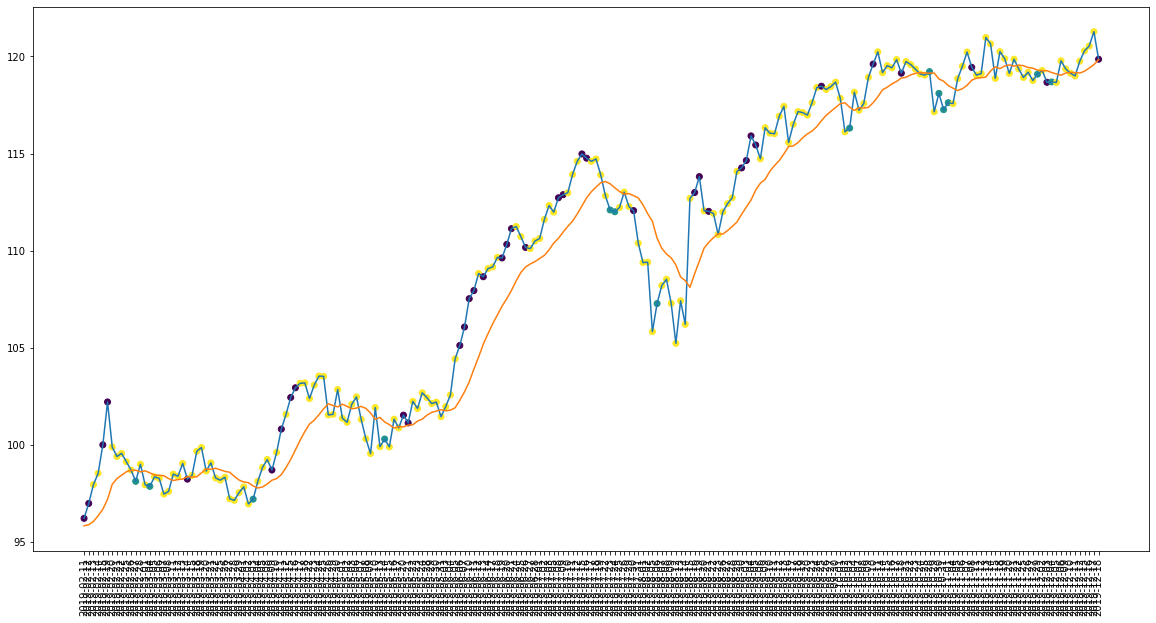

In [119]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

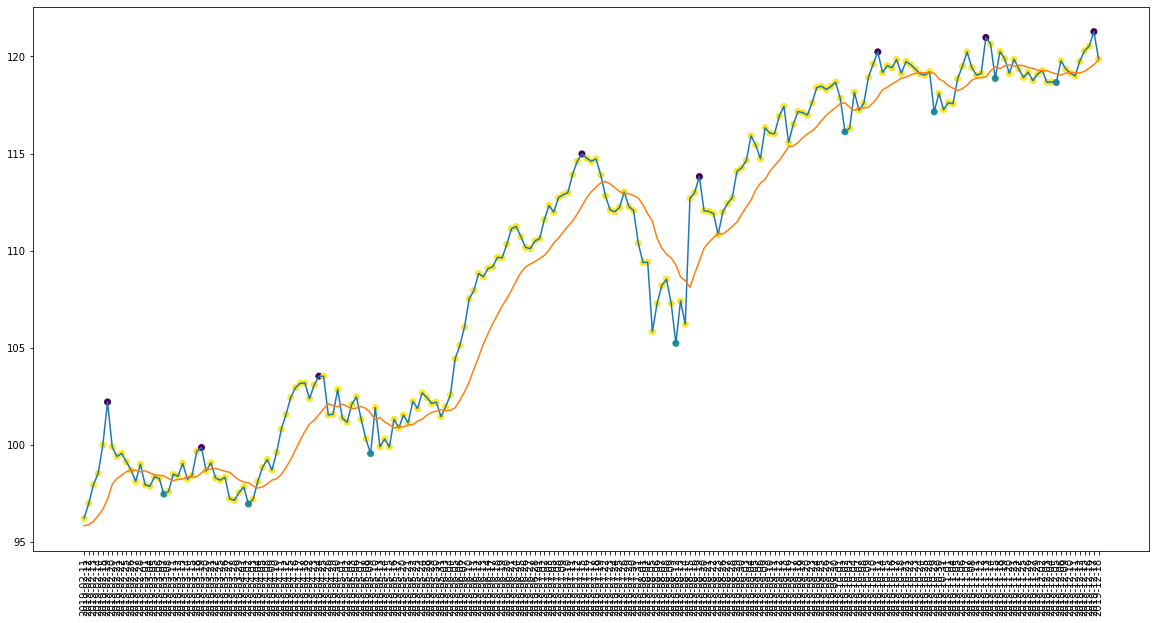

In [120]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [121]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 5
actual holds but predicted buy: 14
actual holds but predicted sell: 35
actual predicted holds: 153
Percentage buys correct: 0.0%
Percentage sells correct: 37.5%
Percentage holds correct: 75.74257425742574%
actual buys: 8
actual sells: 8
actual holds: 202


In [122]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[96.1999969482422, 96.97000122070312, 97.94000244140624, 98.5199966430664, 99.38999938964844, 99.5500030517578, 99.87999725341795, 99.98999786376952, 102.1999969482422]
[97.8499984741211, 97.93000030517578, 98.11000061035156, 98.69000244140624, 98.98999786376952, 99.12000274658205, 99.38999938964844, 99.5500030517578, 99.87999725341795]
Percentage buys correct: 78.57142857142857%
Percentage sells correct: 42.10526315789474%
Percentage holds correct: 84.84848484848484%


In [123]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $98.11000061035156
Shares owned at the moment: 101
Cash capital at the moment: $63.63988568496643


Price increase from previously bought: 6.8410357465927385%
Share price: $105.11000061035156
Shares owned at the moment: 0
Cash capital at the moment: $10650.555644660948


Share price: $112.08999633789062
Shares owned at the moment: 94
Cash capital at the moment: $85.12072484588498


Stop Loss Activated!

Share price: $105.81999969482422
Shares owned at the moment: 0
Cash capital at the moment: $10004.846226238249


Share price: $107.2699966430664
Shares owned at the moment: 93
Cash capital at the moment: $1.3022367916091753


Price increase from previously bought: 5.043470718139287%
Share price: $112.98999786376952
Shares owned at the moment: 0
Cash capital at the moment: $10480.474846168514


Share price: $116.30999755859376
Shares owned at the moment: 89
Cash capital at the moment: $100.41819155120174




Capital at the end of test period: $10738.622510723108
profit gaine

In [124]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12375.78138288879
profit gained: 23.7578138288879%


### Recession

In [125]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test2.csv")
df.set_index('Date', inplace=True)
df = df.iloc[10:]
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2020-02-05,115.269997,115.577902,-41.666781,-15247800.0,2.0
2020-02-06,116.809998,115.767455,-6.982095,-9564900.0,2.0
2020-02-07,116.309998,115.850923,-20.219894,-14917800.0,2.0
2020-02-10,116.449997,115.943088,-17.142986,-11228200.0,2.0
2020-02-11,115.250000,115.836459,-43.516528,-17373100.0,2.0


In [126]:
labels = []
data_5 = []
sequential = []
count = 0

for i in df.values:
    if count == 4:
        data_5.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_arr = min_max_scaler.fit_transform(data_5)
        sequential.append(data_5_arr)
        data_5 = data_5[1:5]
    else:
        data_5.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 5, 4)
y = labels
y = np.array(y)
X.shape

(219, 5, 4)

In [127]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [128]:
model = tf.keras.models.load_model("models/wmt_time_series_lstm_buy_hold_sell_5.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1515 - accuracy: 0.7945 - mean_squared_error: 8.8104 - weighted_accuracy: 0.7945 - weighted_mean_squared_error: 8.8104
Test loss: 0.15154112875461578
Test accuracy: 0.7945205569267273


In [129]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 190, 1: 14, 0: 15})

In [130]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [131]:
df = df.iloc[4:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,115.400002,115.836459,-43.516528,-17373100.0,2.0,2,2
2020-02-12,115.849998,115.769312,-40.219793,-11576300.0,2.0,2,2
2020-02-13,117.440002,115.781725,-30.329757,-6840700.0,2.0,2,2
2020-02-14,117.889999,116.036845,-2.057582,-1507500.0,2.0,2,2
2020-02-18,119.629997,116.321946,-14.561040,6623100.0,0.0,2,0


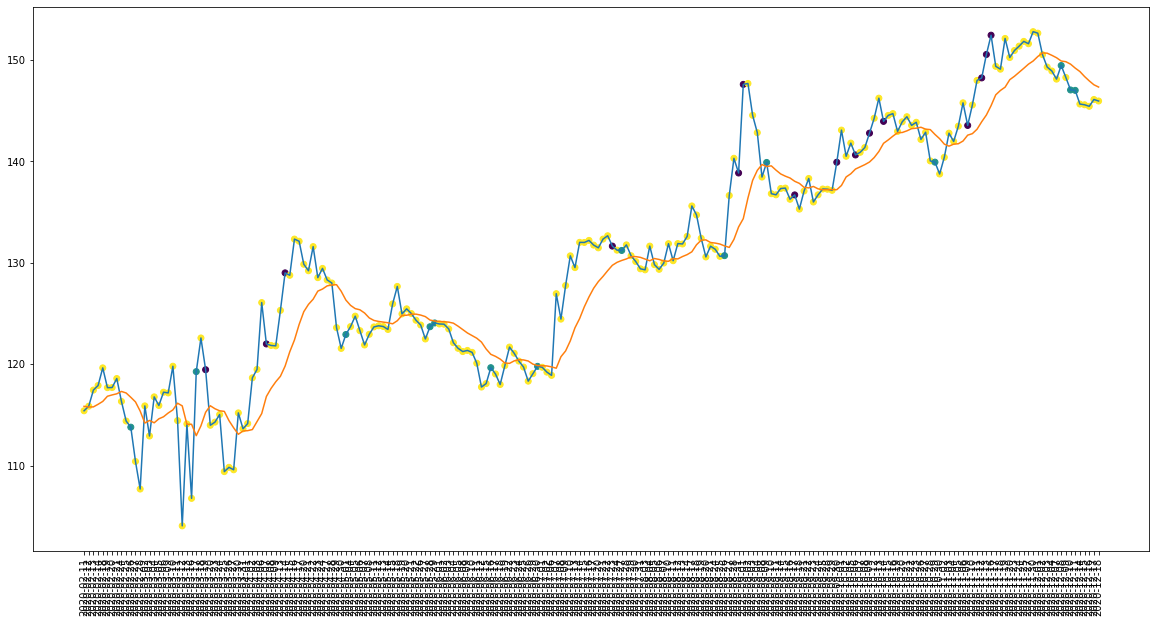

In [132]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

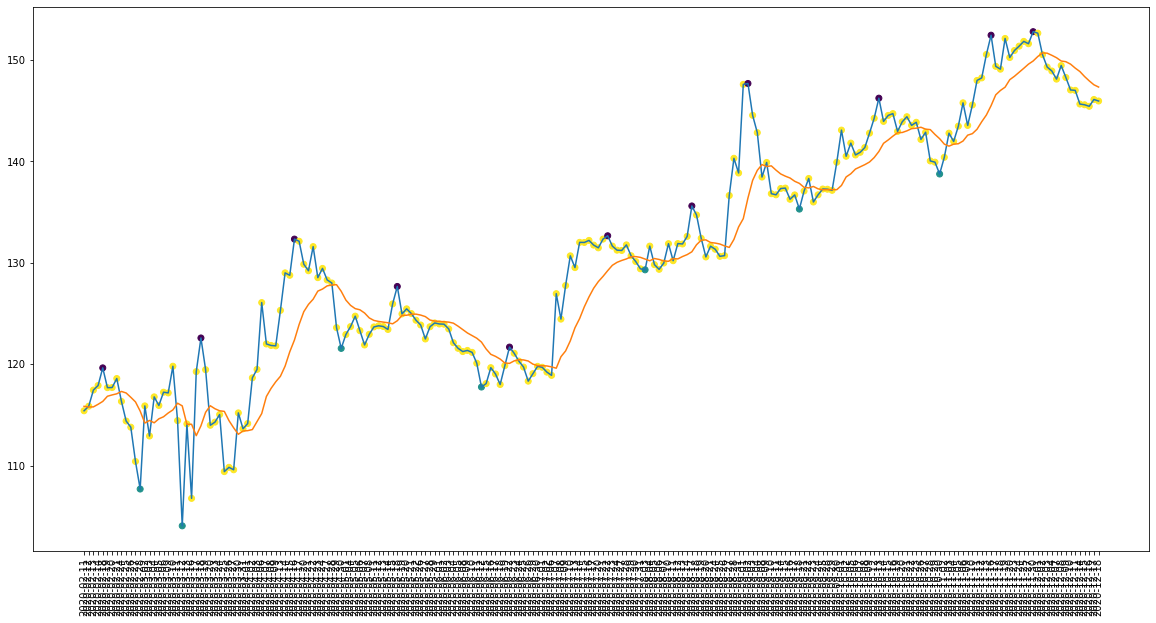

In [133]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [134]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 10
actual holds but predicted buy: 14
actual holds but predicted sell: 14
actual predicted holds: 173
Percentage buys correct: 0.0%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 86.06965174129353%
actual buys: 7
actual sells: 11
actual holds: 201


In [135]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[115.4000015258789, 115.8499984741211, 116.31999969482422, 117.44000244140624, 117.68000030517578, 117.69000244140624, 117.88999938964844, 118.58000183105469, 119.62999725341795]
[107.68000030517578, 110.4000015258789, 112.91000366210938, 113.77999877929688, 114.38999938964844, 115.87999725341795, 116.31999969482422, 117.69000244140624, 118.58000183105469]
Percentage buys correct: 42.857142857142854%
Percentage sells correct: 40.0%
Percentage holds correct: 83.5978835978836%


In [136]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $113.77999877929688
Shares owned at the moment: 87
Cash capital at the moment: $73.91824149322565


Stop Loss Activated!

Share price: $110.4000015258789
Shares owned at the moment: 0
Cash capital at the moment: $9652.305173879624


Share price: $119.26000213623048
Shares owned at the moment: 80
Cash capital at the moment: $85.26780251121272


Stop Loss Activated!

Share price: $113.97000122070312
Shares owned at the moment: 0
Cash capital at the moment: $9177.794499898908


Share price: $122.91999816894531
Shares owned at the moment: 74
Cash capital at the moment: $56.70041576957374


Stop Loss Activated!

Share price: $117.73999786376952
Shares owned at the moment: 0
Cash capital at the moment: $8745.50016812324


Share price: $119.6500015258789
Shares owned at the moment: 72
Cash capital at the moment: $107.00935795783516


Price increase from previously bought: 9.719164658962075%
Share price: $131.63999938964844
Shares owned at the moment: 0
Cash capital at the moment:

In [137]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12565.490331684112
profit gained: 25.65490331684112%


## JP Morgan

In [139]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14     OBV_7  labels
0  2000-01-21       8.7500  8.946622 -66.666667   78200.0     2.0
1  2000-01-24       8.8750  8.935603 -58.333333   99900.0     2.0
2  2000-01-25       9.0000  8.945511 -50.000000  123600.0     2.0
3  2000-01-26       8.6875  8.905817 -70.833333   87300.0     2.0
4  2000-01-27       8.5625  8.852999 -76.000000   32400.0     2.0


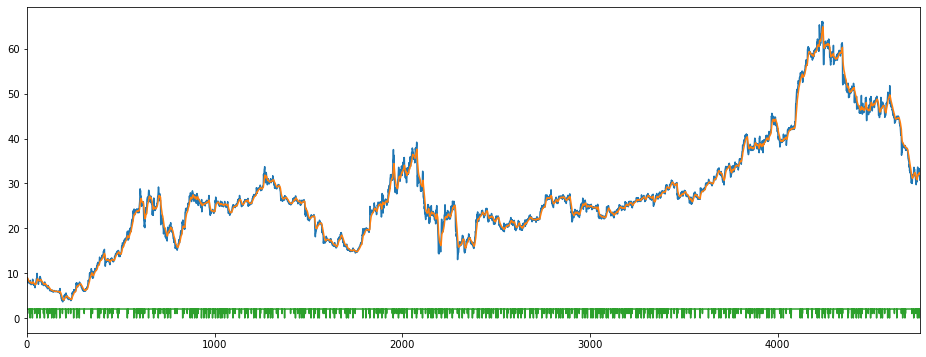

In [140]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [141]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,8.7500,8.946622,-66.666667,78200.0,2.0
2000-01-24,8.8750,8.935603,-58.333333,99900.0,2.0
2000-01-25,9.0000,8.945511,-50.000000,123600.0,2.0
2000-01-26,8.6875,8.905817,-70.833333,87300.0,2.0
2000-01-27,8.5625,8.852999,-76.000000,32400.0,2.0


In [142]:
labels = []
data_5 = []
sequential = []
count = 0

for i in df.values:
    if count == 4:
        data_5.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_arr = min_max_scaler.fit_transform(data_5)
        sequential.append(data_5_arr)
        data_5 = data_5[1:5]
    else:
        data_5.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 5, 4)
y = labels
y = np.array(y)
X.shape

(4755, 5, 4)

In [143]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [144]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [145]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [146]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [147]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 1 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 28ms/step - loss: 0.2705 - accuracy: 0.4624 - mse: 0.4635 - weighted_accuracy: 0.3948 - weighted_mse: 0.4972 - val_loss: 0.3001 - val_accuracy: 0.0463 - val_mse: 0.3466 - val_weighted_accuracy: 0.0463 - val_weighted_mse: 0.3466
Epoch 2/200
30/30 [==============================] - 0s 6ms/step - loss: 0.2035 - accuracy: 0.2915 - mse: 0.7880 - weighted_accuracy: 0.5054 - weighted_mse: 0.7584 - val_loss: 0.2905 - val_accuracy: 0.0463 - val_mse: 0.3675 - val_weighted_accuracy: 0.0463 - val_weighted_mse: 0.3675
Epoch 3/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1833 - accuracy: 0.2655 - mse: 1.0413 - weighted_accuracy: 0.5336 - weighted_mse: 0.9990 - val_loss: 0.2776 - val_accuracy: 0.0463 - val_mse: 0.3934 - val_weighted_accuracy: 0.0463 - val_weighted_mse: 0.3934
Epoch 4/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1752 - accuracy: 0.2739 - mse: 1.2051 - weighted_accuracy: 0.5691 - weighte

Epoch 30/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1391 - accuracy: 0.4393 - mse: 1.5894 - weighted_accuracy: 0.6931 - weighted_mse: 1.5223 - val_loss: 0.1889 - val_accuracy: 0.3743 - val_mse: 1.5169 - val_weighted_accuracy: 0.3743 - val_weighted_mse: 1.5169
Epoch 31/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1392 - accuracy: 0.4508 - mse: 1.5996 - weighted_accuracy: 0.7009 - weighted_mse: 1.5320 - val_loss: 0.1758 - val_accuracy: 0.4543 - val_mse: 1.5040 - val_weighted_accuracy: 0.4543 - val_weighted_mse: 1.5040
Epoch 32/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1379 - accuracy: 0.4432 - mse: 1.6032 - weighted_accuracy: 0.6999 - weighted_mse: 1.5318 - val_loss: 0.1821 - val_accuracy: 0.4111 - val_mse: 1.5551 - val_weighted_accuracy: 0.4111 - val_weighted_mse: 1.5551
Epoch 33/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1366 - accuracy: 0.4698 - mse: 1.6246 - weighted_accuracy: 0.7007 - weig

Epoch 59/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1146 - accuracy: 0.5752 - mse: 1.9065 - weighted_accuracy: 0.7826 - weighted_mse: 1.8285 - val_loss: 0.1767 - val_accuracy: 0.5142 - val_mse: 1.9823 - val_weighted_accuracy: 0.5142 - val_weighted_mse: 1.9823
Epoch 60/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1138 - accuracy: 0.5641 - mse: 1.9637 - weighted_accuracy: 0.7803 - weighted_mse: 1.8697 - val_loss: 0.1634 - val_accuracy: 0.5552 - val_mse: 1.9079 - val_weighted_accuracy: 0.5552 - val_weighted_mse: 1.9079
Epoch 61/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1141 - accuracy: 0.5854 - mse: 1.9290 - weighted_accuracy: 0.7919 - weighted_mse: 1.8490 - val_loss: 0.1621 - val_accuracy: 0.5678 - val_mse: 1.9134 - val_weighted_accuracy: 0.5678 - val_weighted_mse: 1.9134
Epoch 62/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1139 - accuracy: 0.6151 - mse: 1.9462 - weighted_accuracy: 0.8028 - weig

Epoch 88/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0954 - accuracy: 0.6914 - mse: 2.3500 - weighted_accuracy: 0.8523 - weighted_mse: 2.2470 - val_loss: 0.1620 - val_accuracy: 0.5962 - val_mse: 2.3512 - val_weighted_accuracy: 0.5962 - val_weighted_mse: 2.3512
Epoch 89/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0928 - accuracy: 0.6866 - mse: 2.3413 - weighted_accuracy: 0.8561 - weighted_mse: 2.2363 - val_loss: 0.1520 - val_accuracy: 0.6509 - val_mse: 2.4391 - val_weighted_accuracy: 0.6509 - val_weighted_mse: 2.4391
Epoch 90/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0915 - accuracy: 0.7093 - mse: 2.3539 - weighted_accuracy: 0.8680 - weighted_mse: 2.2489 - val_loss: 0.1799 - val_accuracy: 0.5552 - val_mse: 2.5258 - val_weighted_accuracy: 0.5552 - val_weighted_mse: 2.5258
Epoch 91/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0902 - accuracy: 0.7127 - mse: 2.4016 - weighted_accuracy: 0.8729 - weig

Epoch 117/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0735 - accuracy: 0.7852 - mse: 3.0388 - weighted_accuracy: 0.9122 - weighted_mse: 2.8513 - val_loss: 0.1769 - val_accuracy: 0.6267 - val_mse: 3.3245 - val_weighted_accuracy: 0.6267 - val_weighted_mse: 3.3245
Epoch 118/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0733 - accuracy: 0.7779 - mse: 3.1153 - weighted_accuracy: 0.9058 - weighted_mse: 2.9102 - val_loss: 0.1585 - val_accuracy: 0.6625 - val_mse: 3.2470 - val_weighted_accuracy: 0.6625 - val_weighted_mse: 3.2470
Epoch 119/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0745 - accuracy: 0.7700 - mse: 3.1129 - weighted_accuracy: 0.9011 - weighted_mse: 2.8972 - val_loss: 0.1585 - val_accuracy: 0.6740 - val_mse: 3.2046 - val_weighted_accuracy: 0.6740 - val_weighted_mse: 3.2046
Epoch 120/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0706 - accuracy: 0.7994 - mse: 3.1646 - weighted_accuracy: 0.9137 - 

Epoch 146/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0606 - accuracy: 0.8123 - mse: 4.0503 - weighted_accuracy: 0.9203 - weighted_mse: 3.6903 - val_loss: 0.1718 - val_accuracy: 0.6824 - val_mse: 4.0934 - val_weighted_accuracy: 0.6824 - val_weighted_mse: 4.0934
Epoch 147/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0582 - accuracy: 0.8362 - mse: 4.1829 - weighted_accuracy: 0.9309 - weighted_mse: 3.7433 - val_loss: 0.1551 - val_accuracy: 0.7182 - val_mse: 4.3648 - val_weighted_accuracy: 0.7182 - val_weighted_mse: 4.3648
Epoch 148/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0587 - accuracy: 0.8344 - mse: 4.3258 - weighted_accuracy: 0.9266 - weighted_mse: 3.8994 - val_loss: 0.1549 - val_accuracy: 0.7171 - val_mse: 4.2193 - val_weighted_accuracy: 0.7171 - val_weighted_mse: 4.2193
Epoch 149/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0569 - accuracy: 0.8436 - mse: 4.2632 - weighted_accuracy: 0.9318 - 

30/30 [==============================] - 0s 6ms/step - loss: 0.0472 - accuracy: 0.8717 - mse: 5.2933 - weighted_accuracy: 0.9457 - weighted_mse: 4.6210 - val_loss: 0.1680 - val_accuracy: 0.7319 - val_mse: 5.3662 - val_weighted_accuracy: 0.7319 - val_weighted_mse: 5.3662
Epoch 175/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0450 - accuracy: 0.8812 - mse: 5.3387 - weighted_accuracy: 0.9528 - weighted_mse: 4.5826 - val_loss: 0.1865 - val_accuracy: 0.7277 - val_mse: 5.4849 - val_weighted_accuracy: 0.7277 - val_weighted_mse: 5.4849
Epoch 176/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0456 - accuracy: 0.8793 - mse: 5.3929 - weighted_accuracy: 0.9539 - weighted_mse: 4.6739 - val_loss: 0.1687 - val_accuracy: 0.7508 - val_mse: 6.0113 - val_weighted_accuracy: 0.7508 - val_weighted_mse: 6.0113
Epoch 177/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0436 - accuracy: 0.8843 - mse: 5.4905 - weighted_accuracy: 0.9575 - weighted_mse: 

In [148]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1850621998310089
Test accuracy: 0.738170325756073


In [149]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.436206   -4.35163    -0.27081296]
 [-2.9133852  -0.6531232  -0.3603677 ]
 [-2.4082372  -1.3317108   0.8988296 ]
 ...
 [-5.688439   -1.9130486   1.8826742 ]
 [-5.837339   -0.58551186  1.5231743 ]
 [-3.1376956   0.05021841 -0.24188614]]


Counter({2: 764, 0: 74, 1: 113})

In [150]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 864, 0: 43, 1: 44})

In [151]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 951
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 36
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 37
actual holds but predicted buy: 106
actual holds but predicted sell: 67
actual predicted holds: 691
Percentage buys correct: 13.636363636363637%
Percentage sells correct: 11.627906976744185%
Percentage holds correct: 79.97685185185185%
actual buys: 44
actual sells: 43
actual holds: 864


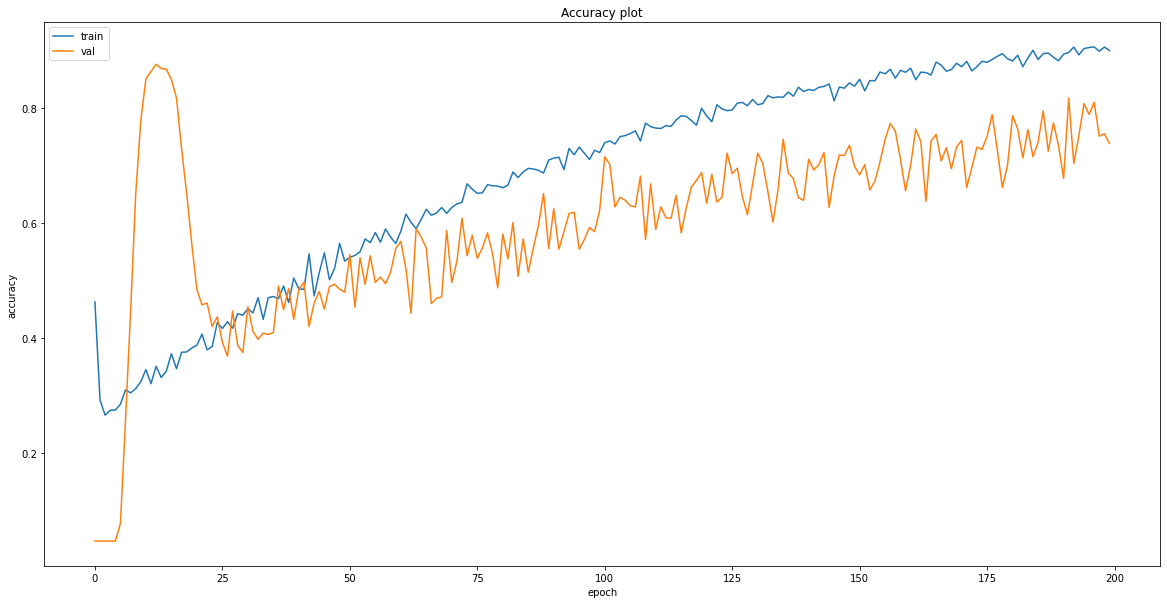

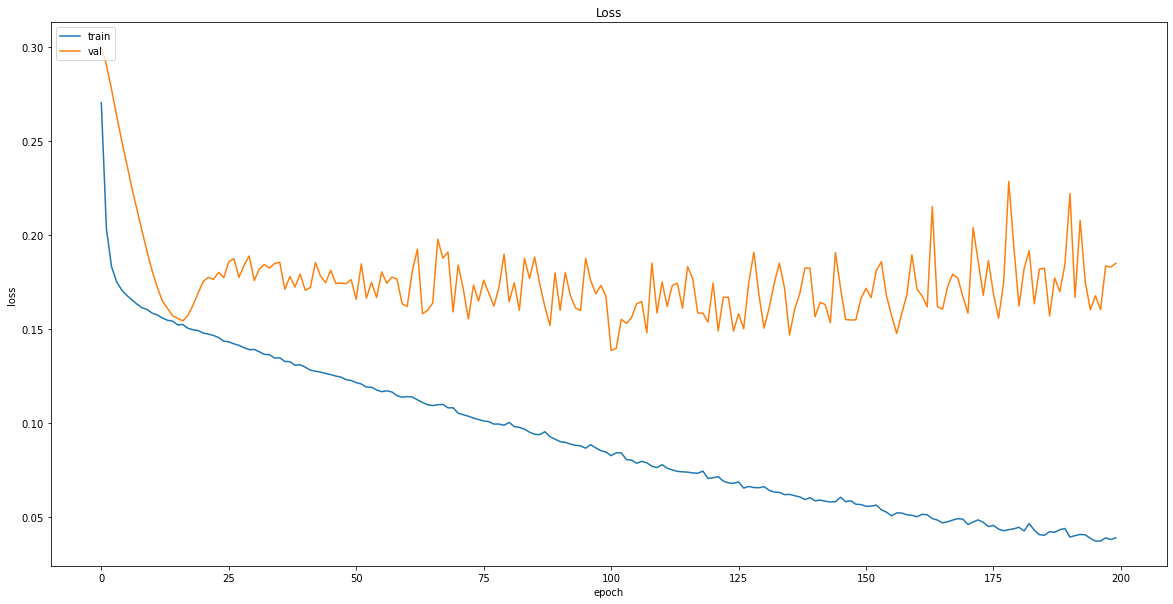

In [152]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [153]:
# Save model
model.save("models/{}".format('FDP_time_series_lstm_buy_hold_sell_5.model'))

INFO:tensorflow:Assets written to: models/FDP_time_series_lstm_buy_hold_sell_5.model\assets


### Test Performance

### non-recession

In [154]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test.csv")
df.set_index('Date', inplace=True)
df = df.iloc[10:]
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-02-05,32.270000,31.221691,-2.583014,2341900.0,2.0
2019-02-06,32.529999,31.422969,-6.451637,2446400.0,2.0
2019-02-07,32.380001,31.570205,-12.698342,2354600.0,2.0
2019-02-08,32.240002,31.673251,-17.589484,2224500.0,2.0
2019-02-11,33.660000,31.978904,-0.753738,2502700.0,2.0


In [155]:
labels = []
data_5 = []
sequential = []
count = 0

for i in df.values:
    if count == 4:
        data_5.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_arr = min_max_scaler.fit_transform(data_5)
        sequential.append(data_5_arr)
        data_5 = data_5[1:5]
    else:
        data_5.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 5, 4)
y = labels
y = np.array(y)
X.shape

(218, 5, 4)

In [156]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [157]:
model = tf.keras.models.load_model("models/FDP_time_series_lstm_buy_hold_sell_5.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 2ms/step - loss: 0.2106 - accuracy: 0.7202 - mean_squared_error: 6.3923 - weighted_accuracy: 0.7202 - weighted_mean_squared_error: 6.3923
Test loss: 0.21063284575939178
Test accuracy: 0.7201834917068481


In [158]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 164, 0: 27, 1: 27})

In [159]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [160]:
df = df.iloc[4:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,33.880001,31.978904,-0.753738,2502700.0,2.0,2,2
2019-02-12,34.610001,32.271381,-0.536205,2611700.0,2.0,0,2
2019-02-13,34.810001,32.631168,-5.603413,2713000.0,2.0,0,2
2019-02-14,34.430000,32.966373,-5.668932,2794100.0,2.0,2,2
2019-02-15,35.220001,33.191547,-14.285733,2675800.0,0.0,2,0


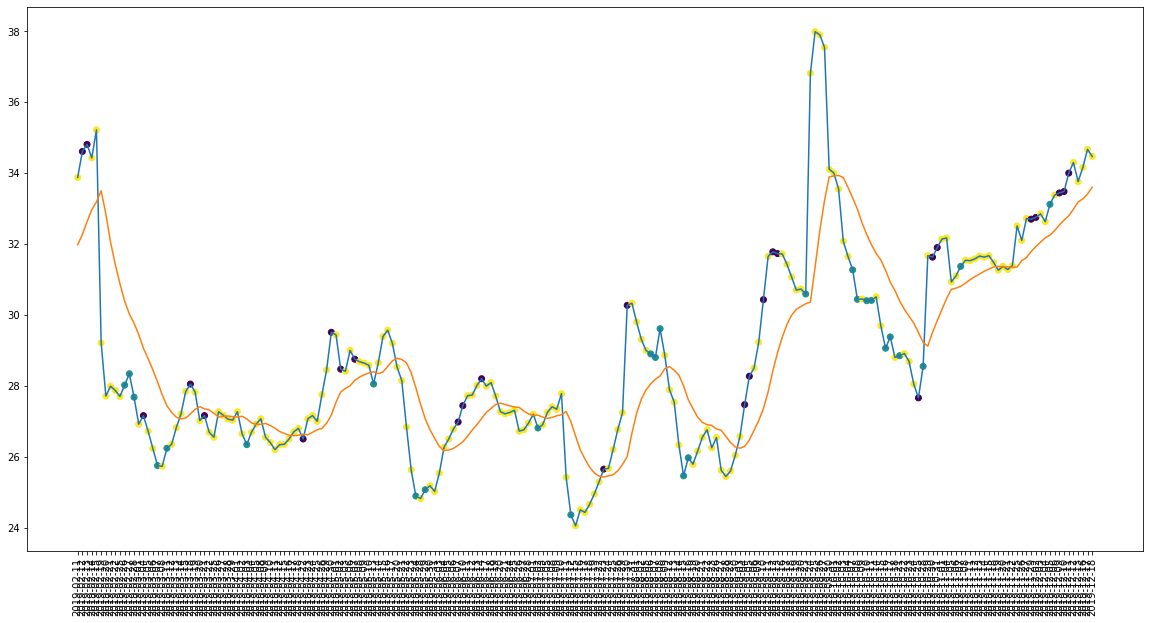

In [161]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

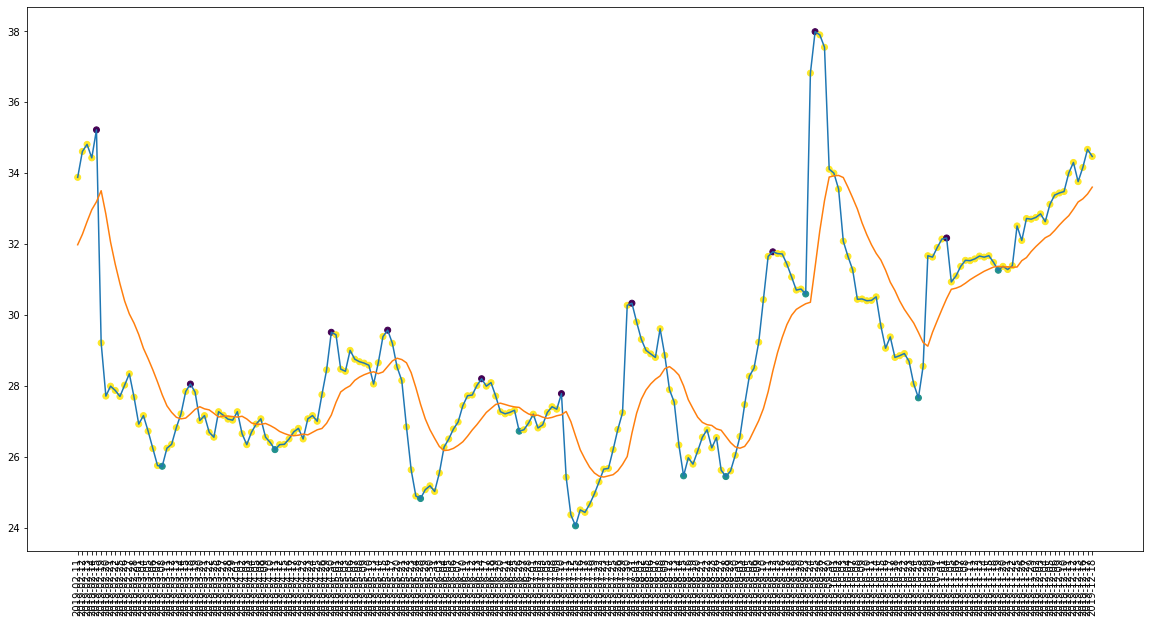

In [162]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [163]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 6
actual holds but predicted buy: 25
actual holds but predicted sell: 22
actual predicted holds: 151
Percentage buys correct: 20.0%
Percentage sells correct: 40.0%
Percentage holds correct: 76.26262626262626%
actual buys: 10
actual sells: 10
actual holds: 198


In [164]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[27.709999084472656, 27.8700008392334, 27.989999771118164, 29.209999084472656, 33.880001068115234, 34.43000030517578, 34.610000610351555, 34.810001373291016, 35.220001220703125]
[26.920000076293945, 27.15999984741211, 27.68000030517578, 27.70000076293945, 27.709999084472656, 27.8700008392334, 27.989999771118164, 28.020000457763672, 28.34000015258789]
Percentage buys correct: 66.66666666666667%
Percentage sells correct: 48.148148148148145%
Percentage holds correct: 85.2760736196319%


In [165]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $28.020000457763672
Shares owned at the moment: 355
Cash capital at the moment: $25.5453120470047


Stop Loss Activated!

Share price: $26.920000076293945
Shares owned at the moment: 0
Cash capital at the moment: $9555.864689056873


Share price: $25.75
Shares owned at the moment: 370
Cash capital at the moment: $2.1640640568730305


Price increase from previously bought: 8.63329431271982%
Share price: $28.04999923706055
Shares owned at the moment: 0
Cash capital at the moment: $10352.122907545569


Share price: $26.34000015258789
Shares owned at the moment: 391
Cash capital at the moment: $24.860762719632476


Price increase from previously bought: 11.727676974614809%
Share price: $29.51000022888184
Shares owned at the moment: 0
Cash capital at the moment: $11531.540224466327


Share price: $28.04999923706055
Shares owned at the moment: 409
Cash capital at the moment: $27.541299866677946


Stop Loss Activated!

Share price: $26.84000015258789
Shares owned at the moment: 0

In [166]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $10118.19906801033
profit gained: 1.1819906801032993%


### recession

In [167]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test2.csv")
df.set_index('Date', inplace=True)
df = df.iloc[10:]
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2020-02-05,31.209999,32.420759,-94.776143,-266300.0,2.0
2020-02-06,32.360001,32.411412,-66.169143,-148200.0,2.0
2020-02-07,32.389999,32.408118,-65.422905,-37200.0,2.0
2020-02-10,33.000000,32.499176,-47.089930,183100.0,2.0
2020-02-11,33.680000,32.680842,-26.373606,310600.0,2.0


In [168]:
labels = []
data_5 = []
sequential = []
count = 0

for i in df.values:
    if count == 4:
        data_5.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_arr = min_max_scaler.fit_transform(data_5)
        sequential.append(data_5_arr)
        data_5 = data_5[1:5]
    else:
        data_5.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 5, 4)
y = labels
y = np.array(y)
X.shape

(219, 5, 4)

In [169]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [170]:
model = tf.keras.models.load_model("models/FDP_time_series_lstm_buy_hold_sell_5.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2127 - accuracy: 0.7763 - mean_squared_error: 6.7538 - weighted_accuracy: 0.7763 - weighted_mean_squared_error: 6.7538
Test loss: 0.2127326875925064
Test accuracy: 0.77625572681427


In [171]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 183, 0: 16, 1: 20})

In [172]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [173]:
df = df.iloc[4:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,33.930000,32.680842,-26.373606,310600.0,2.0,2,2
2020-02-12,34.410000,32.873020,-19.505473,431300.0,2.0,0,2
2020-02-13,34.240002,33.109478,-14.750004,582800.0,2.0,0,2
2020-02-14,34.480000,33.283405,-18.999958,490800.0,0.0,2,0
2020-02-18,34.009998,33.467496,-13.000011,587800.0,2.0,2,2


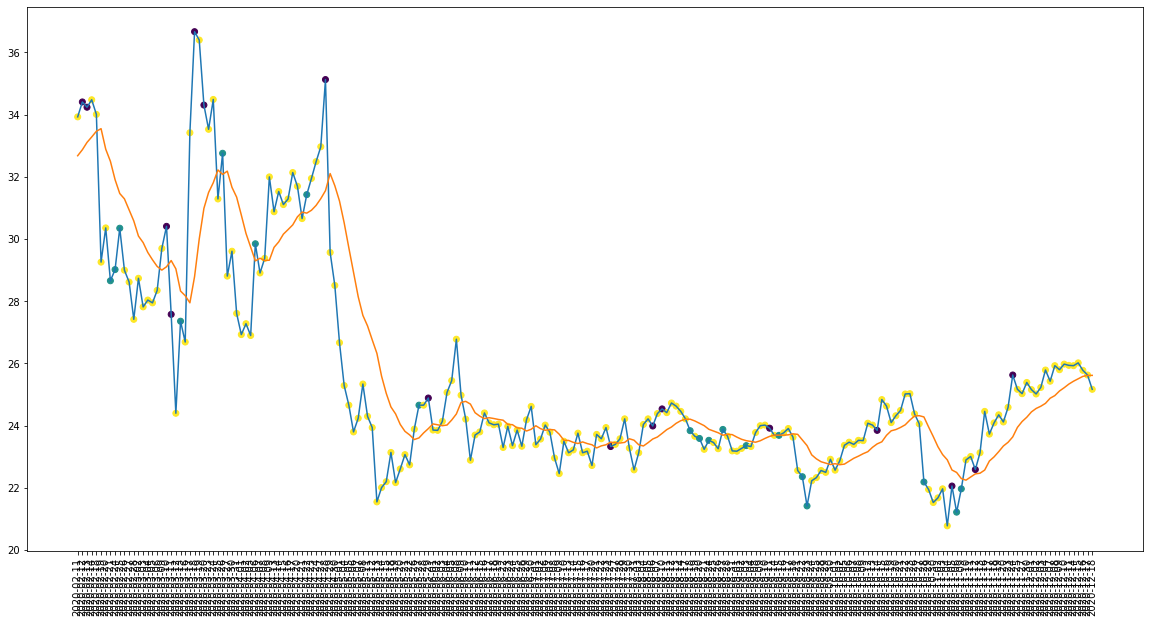

In [174]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

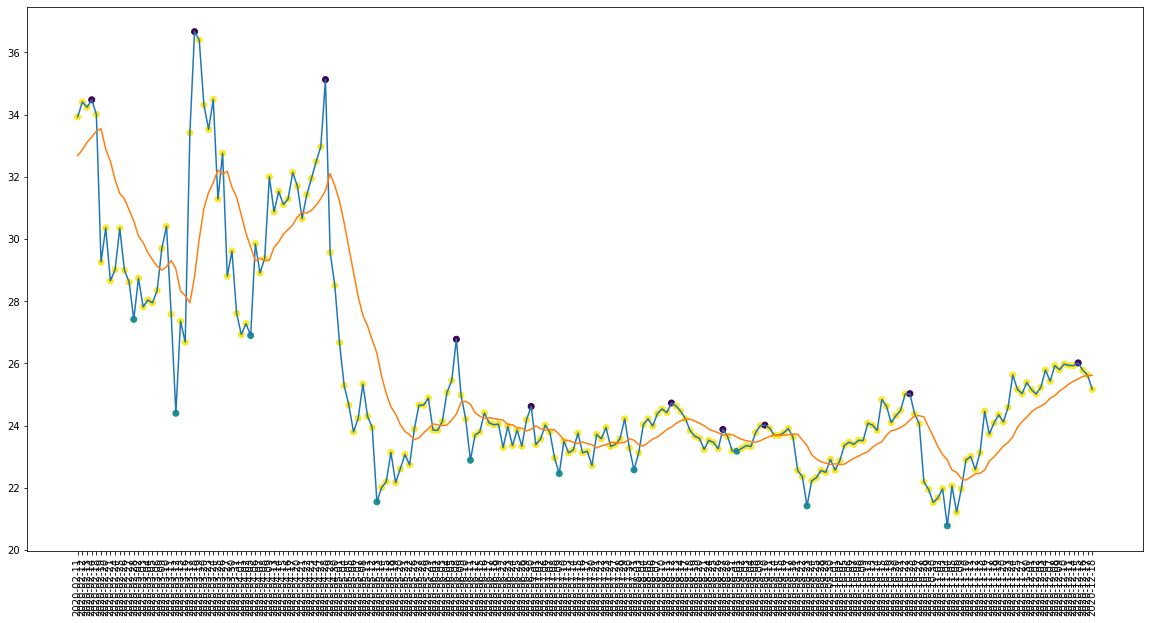

In [175]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [176]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 7
actual holds but predicted buy: 18
actual holds but predicted sell: 14
actual predicted holds: 167
Percentage buys correct: 10.0%
Percentage sells correct: 20.0%
Percentage holds correct: 83.91959798994975%
actual buys: 10
actual sells: 10
actual holds: 199


In [177]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[28.65999984741211, 29.020000457763672, 29.26000022888184, 30.36000061035156, 33.93000030517578, 34.009998321533196, 34.240001678466804, 34.40999984741211, 34.47999954223633]
[27.420000076293945, 27.81999969482422, 28.6200008392334, 28.65999984741211, 28.739999771118164, 29.0, 29.020000457763672, 30.35000038146973, 30.36000061035156]
Percentage buys correct: 47.36842105263158%
Percentage sells correct: 68.75%
Percentage holds correct: 82.51366120218579%


In [178]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $28.65999984741211
Shares owned at the moment: 347
Cash capital at the moment: $27.63124809360488


Stop Loss Activated!

Share price: $27.420000076293945
Shares owned at the moment: 0
Cash capital at the moment: $9516.2057394948


Share price: $27.36000061035156
Shares owned at the moment: 346
Cash capital at the moment: $23.612487732412774


Price increase from previously bought: 33.660202538431385%
Share price: $36.66999816894531
Shares owned at the moment: 0
Cash capital at the moment: $12676.54035092974


Share price: $32.759998321533196
Shares owned at the moment: 385
Cash capital at the moment: $29.25634891653681


Stop Loss Activated!

Share price: $28.809999465942386
Shares owned at the moment: 0
Cash capital at the moment: $11090.60355636979


Share price: $29.85000038146973
Shares owned at the moment: 370
Cash capital at the moment: $15.731039837843127


Stop Loss Activated!

Share price: $28.90999984741211
Shares owned at the moment: 0
Cash capital at the momen

In [179]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7385.700107630253
profit gained: -26.14299892369747%
